# **Predict Future Sales**

# **Dataset Description**
You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

**File descriptions**

**sales_train.csv** - the training set. Daily historical data from January 2013 to October 2015.

**test.csv** - the test set. You need to forecast the sales for these shops and products for November 2015.

**sample_submission.csv** - a sample submission file in the correct format.

**items.csv** - supplemental information about the items/products.

**item_categories.csv ** - supplemental information about the items categories.

**shops.csv**- supplemental information about the shops.

**Data fields**
**ID** - an Id that represents a (Shop, Item) tuple within the test set

**shop_id** - unique identifier of a shop

**item_id** - unique identifier of a product

**item_category_id** - unique identifier of item category

**item_cnt_day** - number of products sold. You are predicting a monthly
amount of this measure

**item_price** - current price of an item

**date** - date in format dd/mm/yyyy

**date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33


**item_name **- name of item

**shop_name** - name of shop

**item_category_name** - name of item category

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import xgboost as xgb
pd.set_option('display.float_format', lambda x: '%.2f' % x)

from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# **Data Loading**

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [68]:
df_test = pd.read_csv('/content/drive/MyDrive/Predict Future Sales/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32',
                                                  'item_id': 'int32'})
df_item_cat = pd.read_csv('/content/drive/MyDrive/Predict Future Sales/item_categories.csv',
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
df_items = pd.read_csv('/content/drive/MyDrive/Predict Future Sales/items.csv', dtype={'item_name': 'str', 'item_id': 'int32',
                                                 'item_category_id': 'int32'})
df_shops = pd.read_csv('/content/drive/MyDrive/Predict Future Sales/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales_train = pd.read_csv('/content/drive/MyDrive/Predict Future Sales/sales_train.csv', parse_dates=['date'],
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32',
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

<ipython-input-68-616899ac076e>:8: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  sales_train = pd.read_csv('/content/drive/MyDrive/Predict Future Sales/sales_train.csv', parse_dates=['date'],


# **Data Quality Check (DQC)**

*Combine datasets to conduct Data Quality Check of raw data train and raw data test*

In [8]:
# Let's write a function for sequential merging of datasets using a common column
def sequential_left_merge(data, *datasets):
    merged_data = data.copy()  # Create a copy of the original data to preserve it

    # Define the common column for the first merge
    common_column = None

    # Iterate over each dataset
    for df in datasets:
        # Find the common column for merging
        if common_column is None:
            common_column = set(data.columns) & set(df.columns)
        else:
            common_column = list(set(merged_data.columns) & set(df.columns))

        # Perform left merge
        merged_data = pd.merge(merged_data, df, on=list(common_column), how='left')

    return merged_data

In [9]:
# Perform the sequential left merge of train data
merged_data = sequential_left_merge(sales_train, df_items, df_item_cat, df_shops)

In [10]:
# Perform the sequential left merge of train data
merged_data_test = sequential_left_merge(df_test, df_items, df_item_cat, df_shops)

# **Quickly check the completeness of the data**

In [11]:
# Data Quality Check (DQC)
def data_quality_check(data):
    try:
        # Check for missing values
        missing_values = data.isnull().sum()
        print("Missing Values:")
        print(missing_values)

        # Check for duplicates
        duplicates = data.duplicated().sum()
        print("\nDuplicates:")
        print(duplicates)

        # Check data types
        data_types = data.dtypes
        data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')
        print("\nData Types:")
        print(data_types)

    except KeyError:
        print("Error: 'date' column not found in the DataFrame.")

# Perform Data Quality Check
print("Data Quality Check 'merged_data':")
data_quality_check(merged_data)
merged_data.describe()

Data Quality Check 'merged_data':
Missing Values:
date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
dtype: int64

Duplicates:
6

Data Types:
date                  datetime64[ns]
date_block_num                 int32
shop_id                        int32
item_id                        int32
item_price                   float32
item_cnt_day                   int32
item_name                     object
item_category_id               int32
item_category_name            object
shop_name                     object
dtype: object


,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00
std,9.42,16.23,6324.30,1729.80,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


In [12]:
print("Data Quality Check 'merged_data_test':")
data_quality_check(merged_data_test)
merged_data.describe()

Data Quality Check 'merged_data_test':
Missing Values:
ID                    0
shop_id               0
item_id               0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
dtype: int64

Duplicates:
0
Error: 'date' column not found in the DataFrame.


,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00
std,9.42,16.23,6324.30,1729.80,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


# **Analyze the completeness**
Let's analyze the completeness of the training dataset and testing dataset in both directions to find out which positions ('shop_id', 'item_id', 'item_category_id') are present in the test dataset but not in the training dataset and vice versa.

In [13]:
# Let's create a column for fixing the store-product couplings we need
merged_data_test['shop_item_id'] = merged_data_test.apply(lambda row: str(row['shop_id']) + '-' + str(row['item_id']), axis=1)
merged_data['shop_item_id'] = merged_data.apply(lambda row: str(row['shop_id']) + '-' + str(row['item_id']), axis=1)

In [10]:
def check_completeness(train, test, columns=['shop_id', 'item_id', 'item_category_id', 'shop_item_id']):
    """
    Check the completeness of specified columns between train and test datasets.

    Args:
        train (DataFrame): The training dataset.
        test (DataFrame): The testing dataset.
        columns (list, optional): List of column names to check completeness. Default is ['shop_id', 'item_id', 'item_category_id', 'shop_item_id'].

    Returns:
        list: A list of formatted strings presenting completeness analysis results for each specified column.

    Example:
        >>> train_data = pd.DataFrame({'shop_id': [1, 2, 3], 'item_id': [101, 102, 103], 'item_category_id': [201, 202, 203]})
        >>> test_data = pd.DataFrame({'shop_id': [1, 2, 4], 'item_id': [101, 102, 104], 'item_category_id': [201, 202, 204]})
        >>> completeness_results = check_completeness(train_data, test_data)
        >>> for result in completeness_results:
        ...     print(result)
        Result of completeness analysis for 'shop_id': Missing in train: 0, Missing in test: 1
        Result of completeness analysis for 'item_id': Missing in train: 0, Missing in test: 1
        Result of completeness analysis for 'item_category_id': Missing in train: 0, Missing in test: 1
        Result of completeness analysis for 'shop_item_id': Missing in train: 0, Missing in test: 0
    """
    completeness_results = {}

    for col in columns:
        train_values = set(train[col].unique())
        test_values = set(test[col].unique())

        missing_in_train = test_values - train_values
        missing_in_test = train_values - test_values

        completeness_results[col] = {
            'missing_in_train': missing_in_train,
            'missing_in_test': missing_in_test
        }

    # Format the results for clearer presentation
    formatted_results = []
    for col, result in completeness_results.items():
        formatted_results.append(f"Result of completeness analysis for '{col}': "
                                  f"Missing in train: {len(result['missing_in_train'])}, "
                                  f"Missing in test: {len(result['missing_in_test'])}")

    return formatted_results

completeness_results = check_completeness(merged_data, merged_data_test)
for result in completeness_results:
    print(result)

Result of completeness analysis for 'shop_id': Missing in train: 0, Missing in test: 18
Result of completeness analysis for 'item_id': Missing in train: 363, Missing in test: 17070
Result of completeness analysis for 'item_category_id': Missing in train: 0, Missing in test: 22
Result of completeness analysis for 'shop_item_id': Missing in train: 102796, Missing in test: 312720


In [14]:
# Let's select only the observations we need
list_test = set(merged_data_test.shop_item_id)
intersect_train = merged_data[merged_data.shop_item_id.isin(list_test)]
mean_intersect_train = pd.DataFrame(intersect_train.groupby(['shop_item_id','date_block_num'])['date_block_num'].mean())
mean_intersect_train.date_block_num.mean()

20.158762927824128


# **CONCLUSIONS ABOUT THE COMPLETENESS OF THE TRAINING SET**
**We are dealing with a very incomplete training set:**

1. The training sample contains all the stores and product categories that are in the test, but it lacks observations for 363 product positions.

2. The number of store-product couplings present in test, but absent in train: 102796, which is 33.0% of the number of observations. Moreover, according to the existing observations of store-product links, the average number of monthly data is 20, instead of 33.

**How ​​much larger is the training set than the test set:**

The number of excess magazines in the training set is 18.

The number of excess products in the training set is 17070 items.

The number of redundant product categories in the training set is 22.

Number of elements present in train but not in test: 312720.


# **Extract, Transform, Load (ETL):**

Performs grouping of data by month, development of functions for creating new predictors from a time stamp, from a description of categorical data and store names. Removes unnecessary columns. Converts categorical variables to numeric variables using label encoding. Saves the transformed data to a new CSV file named "transformed_sales_data.csv".
We will use the dataset we have already combined 'merged_data'.

# **Cleaning a raw dataset from obvious outliers**

Let's filter our dataset for obvious outliers in sales if they go beyond the specified quantiles grouped by data categories

In [86]:
def filter_outliers(df, column_names, lower_quantile=0.05, upper_quantile=0.95, groupby_column='item_category_id'):
    """
    Filters outliers from a DataFrame based on quantiles of specified columns within each category.

    Parameters:
    - df: pandas.DataFrame to filter.
    - column_names: List of column names (e.g., ['item_cnt_day', 'item_price']) to apply the outlier filter on.
    - lower_quantile: Lower quantile threshold for filtering (default is 0.001).
    - upper_quantile: Upper quantile threshold for filtering (default is 0.999).
    - groupby_column: Column name to group by before filtering (default is 'category').

    Returns:
    - filtered_df: DataFrame with outliers removed based on the specified columns.
    """
    for column_name in column_names:
        outlier_mask = df.groupby(groupby_column)[column_name].transform(
            lambda x: (x < x.quantile(lower_quantile)) | (x > x.quantile(upper_quantile))
        )
        df = df[~outlier_mask]
    return df

filtered_train = filter_outliers(merged_data, column_names = ['item_cnt_day'])
print(f'The number of observations after clearing emissions decreased by {len(merged_data) - len(filtered_train)}')

The number of observations after clearing emissions decreased by 98674


In [105]:
# def filter_outliers(df, column_names, lower_zscore=-3, upper_zscore=3, groupby_column='item_category_id'):
#     """
#     Filters outliers from a DataFrame based on z-scores of specified columns within each category.

#     Parameters:
#     - df: pandas.DataFrame to filter.
#     - column_names: List of column names (e.g., ['item_cnt_day', 'item_price']) to apply the outlier filter on.
#     - lower_zscore: Lower z-score threshold for filtering (default is -2).
#     - upper_zscore: Upper z-score threshold for filtering (default is 2).
#     - groupby_column: Column name to group by before filtering (default is 'category').

#     Returns:
#     - filtered_df: DataFrame with outliers removed based on the specified columns.
#     """
#     for column_name in column_names:
#         z_scores = df.groupby(groupby_column)[column_name].transform(lambda x: (x - x.mean()) / x.std())
#         outlier_mask = (z_scores < lower_zscore) | (z_scores > upper_zscore)
#         df = df[~outlier_mask]
#     return df

# filtered_train = filter_outliers(merged_data, column_names=['item_cnt_day'])
# print(f'The number of observations after removing outliers decreased by {len(merged_data) - len(filtered_train)}')

The number of observations after removing outliers decreased by 45275


# **1.2. Grouping sales quantity values ​​in a dataset by month**

In [69]:
# grouped_data = merged_data.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id','item_category_name',
#        'shop_name'], as_index=False).agg({'item_price':['min','mean'], 'item_cnt_day':['sum']})
# # Rename features.
# grouped_data.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id','item_category_name',
#        'shop_name','item_price_min','item_price_mean','item_cnt']
# grouped_data

,date_block_num,shop_id,item_category_id,item_id,item_category_name,shop_name,item_price_min,item_price_mean,item_cnt
0,0,0,2,5572,Аксессуары - PS3,"!Якутск Орджоникидзе, 56 фран",1322.00,1322.00,10
1,0,0,2,5573,Аксессуары - PS3,"!Якутск Орджоникидзе, 56 фран",560.00,560.00,1
2,0,0,2,5575,Аксессуары - PS3,"!Якутск Орджоникидзе, 56 фран",806.00,806.00,4
3,0,0,2,5576,Аксессуары - PS3,"!Якутск Орджоникидзе, 56 фран",2231.00,2231.00,5
4,0,0,2,5609,Аксессуары - PS3,"!Якутск Орджоникидзе, 56 фран",2381.00,2381.00,1
...,...,...,...,...,...,...,...,...,...
1609119,33,59,75,5383,Программы - Для дома и офиса,"Ярославль ТЦ ""Альтаир""",4390.00,4390.00,1
1609120,33,59,79,17717,Служебные,"Ярославль ТЦ ""Альтаир""",299.00,802.55,13
1609121,33,59,83,22087,Элементы питания,"Ярославль ТЦ ""Альтаир""",119.00,119.00,6
1609122,33,59,83,22088,Элементы питания,"Ярославль ТЦ ""Альтаир""",119.00,119.00,2


In [87]:
grouped_data = filtered_train.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id','item_category_name',
       'shop_name'], as_index=False).agg({'item_price':['min','mean'], 'item_cnt_day':['sum']})
# Rename features.
grouped_data.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id','item_category_name',
       'shop_name','item_price_min','item_price_mean','item_cnt']
grouped_data

,date_block_num,shop_id,item_category_id,item_id,item_category_name,shop_name,item_price_min,item_price_mean,item_cnt
0,0,0,2,5572,Аксессуары - PS3,"!Якутск Орджоникидзе, 56 фран",1322.00,1322.00,7
1,0,0,2,5573,Аксессуары - PS3,"!Якутск Орджоникидзе, 56 фран",560.00,560.00,1
2,0,0,2,5575,Аксессуары - PS3,"!Якутск Орджоникидзе, 56 фран",806.00,806.00,4
3,0,0,2,5576,Аксессуары - PS3,"!Якутск Орджоникидзе, 56 фран",2231.00,2231.00,5
4,0,0,2,5609,Аксессуары - PS3,"!Якутск Орджоникидзе, 56 фран",2381.00,2381.00,1
...,...,...,...,...,...,...,...,...,...
1601236,33,59,75,5383,Программы - Для дома и офиса,"Ярославль ТЦ ""Альтаир""",4390.00,4390.00,1
1601237,33,59,79,17717,Служебные,"Ярославль ТЦ ""Альтаир""",299.00,802.55,13
1601238,33,59,83,22087,Элементы питания,"Ярославль ТЦ ""Альтаир""",119.00,119.00,6
1601239,33,59,83,22088,Элементы питания,"Ярославль ТЦ ""Альтаир""",119.00,119.00,2


In [88]:
# Create 'price_change' column based on conditions
grouped_data['price_change'] = (grouped_data['item_price_mean'] > grouped_data['item_price_min']).astype(int)
grouped_data = grouped_data.drop(labels = ['item_price_min'],axis=1)

In [ ]:
# class TxtFeature(BaseEstimator, TransformerMixin):

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X, y=None):

#         return X

#     def fit_transform(self, X, y=None):
#         return self.fit(X).transform(X)

# **1.3. Feature Engineering Process**

In [89]:
class FeatureEngineering:
    """Class for performing feature engineering on sales data.

    Attributes:
        None

    Methods:
        feature_engineering(data): Performs feature engineering on the input data.
    """

    def feature_engineering(self, data):
        """Performs feature engineering on the input data.

        Args:
            data (DataFrame): The input DataFrame containing sales data.

        Returns:
            DataFrame: The DataFrame with additional engineered features.
        """
    def feature_engineering(self, data):

        # Generating features from the text string of the category name and store name
        data['item_category_name'] = data['item_category_name'].apply(lambda name: re.sub(r'[^\w\s]', '', str(name).split()[0]).strip())
        data['shop_name'] = data['shop_name'].apply(lambda name: re.sub(r'[^\w\s]', '', str(name).split()[0]).strip())

        # Generating features from a timestamp
        data['year'] = data['date_block_num'].apply(lambda x: ((x // 12) + 2013))
        data['season'] = data['date_block_num'].apply(lambda x: (x % 4))
        data['month'] = data['date_block_num'].apply(lambda x: (x % 12))

        # Calculate the average 'item_cnt' in the group ['shop_id', 'item_id']
        data['shop_item_cnt_mean'] = data.groupby(['shop_id', 'item_id'])['item_cnt'].transform('mean')
        # Calculate the average 'item_cnt' in the group ['shop_id', 'item_category_id']
        data['shop_item_category_id_cnt_mean'] = data.groupby(['shop_id', 'item_category_id'])['item_cnt'].transform('mean')
        # Calculate the average 'item_cnt' in the group ['shop_id', 'item_category']
        data['shop_item_category_cnt_mean'] = data.groupby(['shop_id', 'item_category_name'])['item_cnt'].transform('mean')
        # Calculate the average 'item_cnt' in the group ['shop_name', 'item_id']
        data['sity_item_id_cnt_mean'] = data.groupby(['shop_name', 'item_id'])['item_cnt'].transform('mean')
        # Calculate the average 'item_cnt' in the group ['shop_name', 'item_category_id']
        data['sity_category_id_cnt_mean'] = data.groupby(['shop_name', 'item_category_id'])['item_cnt'].transform('mean')
        # Calculate the average 'item_cnt' in the group ['shop_name', 'item_category']
        data['sity_item_category_cnt_mean'] = data.groupby(['shop_name', 'item_category_name'])['item_cnt'].transform('mean')
        return data

train_data = grouped_data.copy()
# Создаем экземпляр класса DataProcessor
processor = FeatureEngineering()
# Обрабатываем данные с помощью метода process_data
train_data = processor.feature_engineering(train_data)
train_data

,date_block_num,shop_id,item_category_id,item_id,item_category_name,shop_name,item_price_mean,item_cnt,price_change,year,season,month,shop_item_cnt_mean,shop_item_category_id_cnt_mean,shop_item_category_cnt_mean,sity_item_id_cnt_mean,sity_category_id_cnt_mean,sity_item_category_cnt_mean
0,0,0,2,5572,Аксессуары,Якутск,1322.00,7,0,2013,0,0,7.50,2.68,3.73,2.74,1.94,2.49
1,0,0,2,5573,Аксессуары,Якутск,560.00,1,0,2013,0,0,1.00,2.68,3.73,1.24,1.94,2.49
2,0,0,2,5575,Аксессуары,Якутск,806.00,4,0,2013,0,0,4.00,2.68,3.73,1.50,1.94,2.49
3,0,0,2,5576,Аксессуары,Якутск,2231.00,5,0,2013,0,0,3.50,2.68,3.73,2.17,1.94,2.49
4,0,0,2,5609,Аксессуары,Якутск,2381.00,1,0,2013,0,0,1.00,2.68,3.73,1.00,1.94,2.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1601236,33,59,75,5383,Программы,Ярославль,4390.00,1,0,2015,1,9,1.00,2.39,2.15,1.00,2.39,2.15
1601237,33,59,79,17717,Служебные,Ярославль,802.55,13,1,2015,1,9,16.89,16.89,14.62,16.89,16.89,14.62
1601238,33,59,83,22087,Элементы,Ярославль,119.00,6,0,2015,1,9,6.21,4.78,4.78,6.21,4.78,4.78
1601239,33,59,83,22088,Элементы,Ярославль,119.00,2,0,2015,1,9,5.88,4.78,4.78,5.88,4.78,4.78


# **Feature Engineering operations with the test sample**


**Do the same operations with the test sample**
First we will combine it with the training one, then we will generate all the features. This will have to be done to calculate average sales by store, product and product category.

Let's create a features_for_test dataframe in which, after combining with the test dataframe, the entire feature_engineering stage will be carried out, as was done with the training dataset

In [90]:
features_for_test = merged_data_test[['ID', 'shop_id', 'item_id','item_category_id',	'item_category_name','shop_name']].copy()
features_for_test['date_block_num'] = 34

# Concatenate grouped_data with test
features_for_test = pd.concat([grouped_data, features_for_test])

# Fill missing values with zeros in specified columns
columns_to_fill_with_zeros = ['item_price_mean', 'price_change', 'item_cnt']
features_for_test[columns_to_fill_with_zeros] = features_for_test[columns_to_fill_with_zeros].fillna(0)
# Создаем экземпляр класса DataProcessor
processor = FeatureEngineering()
# Обрабатываем данные с помощью метода process_data
features_for_test = processor.feature_engineering(features_for_test)
features_for_test

,date_block_num,shop_id,item_category_id,item_id,item_category_name,shop_name,item_price_mean,item_cnt,price_change,ID,year,season,month,shop_item_cnt_mean,shop_item_category_id_cnt_mean,shop_item_category_cnt_mean,sity_item_id_cnt_mean,sity_category_id_cnt_mean,sity_item_category_cnt_mean
0,0,0,2,5572,Аксессуары,Якутск,1322.00,7.00,0.00,NaN,2013,0,0,7.50,2.68,3.73,2.61,1.87,2.33
1,0,0,2,5573,Аксессуары,Якутск,560.00,1.00,0.00,NaN,2013,0,0,1.00,2.68,3.73,1.24,1.87,2.33
2,0,0,2,5575,Аксессуары,Якутск,806.00,4.00,0.00,NaN,2013,0,0,4.00,2.68,3.73,1.50,1.87,2.33
3,0,0,2,5576,Аксессуары,Якутск,2231.00,5.00,0.00,NaN,2013,0,0,3.50,2.68,3.73,2.17,1.87,2.33
4,0,0,2,5609,Аксессуары,Якутск,2381.00,1.00,0.00,NaN,2013,0,0,1.00,2.68,3.73,1.00,1.87,2.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,34,45,55,18454,Музыка,Самара,0.00,0.00,0.00,214195.00,2015,2,10,1.50,1.04,0.96,1.33,1.06,0.99
214196,34,45,64,16188,Подарки,Самара,0.00,0.00,0.00,214196.00,2015,2,10,0.00,0.97,1.31,0.00,1.10,1.32
214197,34,45,55,15757,Музыка,Самара,0.00,0.00,0.00,214197.00,2015,2,10,1.00,1.04,0.96,1.00,1.06,0.99
214198,34,45,40,19648,Кино,Самара,0.00,0.00,0.00,214198.00,2015,2,10,0.00,1.24,1.16,0.33,1.24,1.16


# **1.4. Applying LabelEncoder to columns of type object**

In [91]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# Applying LabelEncoder to columns of type objec
df = train_data.copy()
df['item_category_name'] = label_encoder.fit_transform(df['item_category_name'])
df['shop_name'] = label_encoder.fit_transform(df['shop_name'])
df

,date_block_num,shop_id,item_category_id,item_id,item_category_name,shop_name,item_price_mean,item_cnt,price_change,year,season,month,shop_item_cnt_mean,shop_item_category_id_cnt_mean,shop_item_category_cnt_mean,sity_item_id_cnt_mean,sity_category_id_cnt_mean,sity_item_category_cnt_mean
0,0,0,2,5572,1,29,1322.00,7,0,2013,0,0,7.50,2.68,3.73,2.74,1.94,2.49
1,0,0,2,5573,1,29,560.00,1,0,2013,0,0,1.00,2.68,3.73,1.24,1.94,2.49
2,0,0,2,5575,1,29,806.00,4,0,2013,0,0,4.00,2.68,3.73,1.50,1.94,2.49
3,0,0,2,5576,1,29,2231.00,5,0,2013,0,0,3.50,2.68,3.73,2.17,1.94,2.49
4,0,0,2,5609,1,29,2381.00,1,0,2013,0,0,1.00,2.68,3.73,1.00,1.94,2.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1601236,33,59,75,5383,11,30,4390.00,1,0,2015,1,9,1.00,2.39,2.15,1.00,2.39,2.15
1601237,33,59,79,17717,12,30,802.55,13,1,2015,1,9,16.89,16.89,14.62,16.89,16.89,14.62
1601238,33,59,83,22087,14,30,119.00,6,0,2015,1,9,6.21,4.78,4.78,6.21,4.78,4.78
1601239,33,59,83,22088,14,30,119.00,2,0,2015,1,9,5.88,4.78,4.78,5.88,4.78,4.78


# **Let's add monthly lags of the dynamics of changes in our target to the feature space using the structure of the pivot table**

In [92]:
df_pivot = df.pivot_table(
        index = ['shop_id', 'item_category_id', 'item_id',
       'item_category_name', 'shop_name', 'item_price_mean',
       'price_change', 'year', 'season', 'month', 'shop_item_cnt_mean',
       'shop_item_category_id_cnt_mean', 'shop_item_category_cnt_mean',
       'sity_item_id_cnt_mean', 'sity_category_id_cnt_mean',
       'sity_item_category_cnt_mean'],
         columns = 'date_block_num',
         values = 'item_cnt',
         aggfunc='sum').fillna(0.0)


In [93]:
# Сбросить индекс и сохранить результат в df
df1 = df_pivot.reset_index()
# Вернуть 'date_block_num' обратно в df
df1['date_block_num'] = df['date_block_num']
df1['item_cnt'] = df['item_cnt']
# Вернуть 'date_block_num' обратно в df
df1

date_block_num,shop_id,item_category_id,item_id,item_category_name,shop_name,item_price_mean,price_change,year,season,month,...,26,27,28,29,30,31,32,33,date_block_num,item_cnt
0,0,0,16255,0,29,93.00,0,2013,1,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,7
1,0,1,5740,1,29,283.00,0,2013,1,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,1
2,0,2,5570,1,29,93.00,0,2013,1,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,4
3,0,2,5572,1,29,1322.00,0,2013,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,5
4,0,2,5572,1,29,1322.00,0,2013,1,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1601236,59,83,22092,14,30,109.00,0,2014,3,7,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,33,1
1601237,59,83,22092,14,30,139.00,0,2014,3,11,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,33,13
1601238,59,83,22092,14,30,145.67,1,2015,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,33,6
1601239,59,83,22092,14,30,179.00,0,2015,2,2,...,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,33,2


*Let's do the same with the test sample so that we have the same feature space for further application of the model*

*Let's delete all the lines that do not have an ID value, thereby only those positions that are in the test will remain in the test dataframe, that is, we'll delete the training part, we needed it to calculate the averages for the entire dataframe.*


*Apply label_encoder to a test dataset*

In [94]:
test_data = features_for_test.dropna(axis=0, how='any')
test_data['item_category_name'] = label_encoder.fit_transform(test_data['item_category_name'])
test_data['shop_name'] = label_encoder.fit_transform(test_data['shop_name'])

<ipython-input-94-84b0583e51cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['item_category_name'] = label_encoder.fit_transform(test_data['item_category_name'])
<ipython-input-94-84b0583e51cd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['shop_name'] = label_encoder.fit_transform(test_data['shop_name'])


In [95]:
df_pivot_test = test_data.pivot_table(
        index = ['shop_id', 'item_category_id', 'item_id',
       'item_category_name', 'shop_name', 'item_price_mean', 'item_cnt',
       'price_change', 'year', 'season', 'month', 'shop_item_cnt_mean',
       'shop_item_category_id_cnt_mean', 'shop_item_category_cnt_mean',
       'sity_item_id_cnt_mean', 'sity_category_id_cnt_mean',
       'sity_item_category_cnt_mean'],
         columns = 'date_block_num',
         values = 'item_cnt',
         aggfunc='sum').fillna(0.0)

test_data = df_pivot_test.reset_index()

def process_test_data(test_data):
    """
    Process test data by creating columns with names from the list(range(34)) and filling them with zeros.
    Then sorts all columns in the DataFrame by their names alphabetically.

    Args:
    test_data (DataFrame): The input DataFrame containing test data.

    Returns:
    DataFrame: The processed DataFrame.
    """
    # Create columns with names from the list(range(34)) and fill them with zeros
    for i in range(34):
        test_data[i] = 0

    return test_data

processed_test_data = process_test_data(test_data)
processed_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 52 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   shop_id                         214200 non-null  int64  
 1   item_category_id                214200 non-null  int64  
 2   item_id                         214200 non-null  int64  
 3   item_category_name              214200 non-null  int64  
 4   shop_name                       214200 non-null  int64  
 5   item_price_mean                 214200 non-null  float64
 6   item_cnt                        214200 non-null  float64
 7   price_change                    214200 non-null  float64
 8   year                            214200 non-null  int64  
 9   season                          214200 non-null  int64  
 10  month                           214200 non-null  int64  
 11  shop_item_cnt_mean              214200 non-null  float64
 12  shop_item_catego

In [96]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601241 entries, 0 to 1601240
Data columns (total 52 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   shop_id                         1601241 non-null  int64  
 1   item_category_id                1601241 non-null  int64  
 2   item_id                         1601241 non-null  int64  
 3   item_category_name              1601241 non-null  int64  
 4   shop_name                       1601241 non-null  int64  
 5   item_price_mean                 1601241 non-null  float64
 6   price_change                    1601241 non-null  int64  
 7   year                            1601241 non-null  int64  
 8   season                          1601241 non-null  int64  
 9   month                           1601241 non-null  int64  
 10  shop_item_cnt_mean              1601241 non-null  float64
 11  shop_item_category_id_cnt_mean  1601241 non-null  float64
 12  

# **"ЭТАП ПОСТРОЕНИЯ МОДЕЛИ**

In [97]:
sales_train = df1.copy()
# Привести все имена столбцов к строковому типу данных
sales_train.columns = sales_train.columns.astype(str)

In [98]:
from sklearn.model_selection import train_test_split

# Предполагаем, что `sales_train` отсортирован по времени
# Определяем индекс, по которому будем разделять данные
split_index = int(len(sales_train) * 0.9)  # Например, 90% данных для тренировки

# Разделение данных без перемешивания
X_train, X_val = sales_train.iloc[:split_index, :-1], sales_train.iloc[split_index:, :-1]
y_train, y_val = sales_train.iloc[:split_index, -1], sales_train.iloc[split_index:, -1]

# Предположим, что 'date_block_num' = 33 для валидации
X_train = sales_train[sales_train['date_block_num'] < 33].drop(columns=['item_cnt'])
y_train = sales_train[sales_train['date_block_num'] < 33]['item_cnt']
X_val = sales_train[sales_train['date_block_num'] == 33].drop(columns=['item_cnt'])
y_val = sales_train[sales_train['date_block_num'] == 33]['item_cnt']
print(len(X_train))
print(len(X_val))

1569953
31288


In [99]:
sales_train[sales_train['date_block_num'] == 33]['item_cnt'].max()

332

In [100]:
from sklearn import feature_selection
selector = feature_selection.SelectKBest(feature_selection.f_regression, k=25)
selector.fit(X_train, y_train)

best_features = selector.get_feature_names_out()
X_train = X_train[best_features]
X_val = X_val[best_features]

In [107]:
sales_train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,,,,,,,,
shop_id,1601241.00,32.82,16.54,0.00,21.00,31.00,47.00,59.00
item_category_id,1601241.00,41.53,16.32,0.00,30.00,40.00,55.00,83.00
item_id,1601241.00,10683.47,6238.26,0.00,5046.00,10498.00,16062.00,22169.00
item_category_name,1601241.00,7.15,2.08,0.00,5.00,7.00,9.00,14.00
shop_name,1601241.00,16.11,7.67,0.00,13.00,13.00,23.00,30.00
item_price_mean,1601241.00,789.90,1548.68,0.09,199.00,399.00,894.31,307980.00
price_change,1601241.00,0.06,0.23,0.00,0.00,0.00,0.00,1.00
year,1601241.00,2013.79,0.78,2013.00,2013.00,2014.00,2014.00,2015.00
season,1601241.00,1.47,1.12,0.00,0.00,1.00,2.00,3.00


In [101]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1569953 entries, 0 to 1569952
Data columns (total 25 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   shop_id                         1569953 non-null  int64  
 1   item_id                         1569953 non-null  int64  
 2   shop_name                       1569953 non-null  int64  
 3   item_price_mean                 1569953 non-null  float64
 4   price_change                    1569953 non-null  int64  
 5   year                            1569953 non-null  int64  
 6   season                          1569953 non-null  int64  
 7   shop_item_cnt_mean              1569953 non-null  float64
 8   shop_item_category_id_cnt_mean  1569953 non-null  float64
 9   shop_item_category_cnt_mean     1569953 non-null  float64
 10  sity_item_id_cnt_mean           1569953 non-null  float64
 11  sity_category_id_cnt_mean       1569953 non-null  float64
 12  

In [59]:
from sklearn import ensemble
from sklearn import metrics
grad_boost = ensemble.GradientBoostingRegressor(learning_rate=0.5,
                                n_estimators=10,
                                max_depth=6,
                                min_samples_split=20,
                                random_state=42)
grad_boost.fit(X_train, y_train)
y_train_pred = grad_boost.predict(X_train)
y_valid_pred = grad_boost.predict(X_val)
print('метрика RMSLE на тренировочной выборке для модели градиентного бустинга: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))))
print('метрика RMSLE на валидационной выборке для модели градиентного бустинга: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_val, y_valid_pred))))

метрика RMSLE на тренировочной выборке для модели градиентного бустинга: 6.12
метрика RMSLE на валидационной выборке для модели градиентного бустинга: 5.77


метрика RMSLE на тренировочной выборке для модели градиентного бустинга: 6.06
метрика RMSLE на валидационной выборке для модели градиентного бустинга: 6.47

In [47]:
import xgboost as xgb

In [60]:
# from sklearn.model_selection import train_test_split

# # Предполагаем, что `sales_train` отсортирован по времени
# # Определяем индекс, по которому будем разделять данные
# split_index = int(len(sales_train) * 0.9)  # Например, 90% данных для тренировки

# # Разделение данных без перемешивания
# X_train, X_val = sales_train.iloc[:split_index, :-1], sales_train.iloc[split_index:, :-1]
# y_train, y_val = sales_train.iloc[:split_index, -1], sales_train.iloc[split_index:, -1]

# # Или используя дату
# # Предположим, что 'date_block_num' = 34 для валидации
# X_train = sales_train[sales_train['date_block_num'] < 33].drop(columns=['item_cnt'])
# y_train = sales_train[sales_train['date_block_num'] < 33]['item_cnt']
# X_val = sales_train[sales_train['date_block_num'] == 33].drop(columns=['item_cnt'])
# y_val = sales_train[sales_train['date_block_num'] == 33]['item_cnt']
# print(len(X_train))
# print(len(X_val))
# scaler = preprocessing.MinMaxScaler()
# # columns = X_train.columns
# X_train = scaler.fit_transform(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_val = scaler.transform(X_val)
# X_val_scaled = scaler.transform(X_val)

1575662
31477


In [102]:
# feature_names = list(sales_train.drop(columns=['item_cnt']).columns)
feature_names = list(X_train.columns)
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dvalid = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)

In [ ]:
# Создание матриц наблюдений в формате DMatrix
# dtrain = xgb.DMatrix(X_train_scaled, label=y_train, feature_names=feature_names)
# dvalid = xgb.DMatrix(X_val_scaled, label=y_val, feature_names=feature_names)
# dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

In [103]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9,
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1,
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:4.38553	valid-rmse:4.60980
[10]	train-rmse:4.38013	valid-rmse:4.60974
[20]	train-rmse:4.37729	valid-rmse:4.60978
[23]	train-rmse:4.37638	valid-rmse:4.61002


In [ ]:
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import make_union, make_pipeline
# from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, MinMaxScaler, LabelBinarizer, OneHotEncoder
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import MinMaxScaler

# def get_for_Scale_cols(data):
#     return data[['item_price_mean']]

# def get_OneHotEnc_col(data):
#     return data[['shop_name', 'item_category_name']]

# my_prepare = make_union(*[
#     make_pipeline(FunctionTransformer(get_OneHotEnc_col, validate=False),  OneHotEncoder(sparse=False)),
#     make_pipeline(FunctionTransformer(get_for_Scale_cols, validate=False), StandardScaler())
#     ])

# x = my_prepare.fit_transform(df_for_prepare)
# y = df_for_prepare['Class/ASD'].values

Index(['date_block_num', 'shop_id', 'item_category_id', 'item_id',
       'item_price_mean', 'item_cnt', 'price_change', 'ID', 'category', 'city',
       'year', 'season', 'month'],
      dtype='object')

In [ ]:
# Extract, Transform, Load (ETL) stages


def extract_transform_load(data):

    # Feature engineering from timestamp
    processor = FeatureEngineering()
    # Обрабатываем данные с помощью метода feature_engineering
    data = processor.feature_engineering(data)

    # Drop unnecessary columns
    data.drop(columns=['item_price', 'item_name', 'shop_name', 'item_category_name'], inplace=True)

    # Convert categorical variables to numerical using label encoding if needed

    # Save the transformed data to a new CSV file
    # data.to_csv('transformed_sales_data.csv', index=False)

# Perform Extract, Transform, Load (ETL)
print("\nExtract, Transform, Load (ETL):")
extract_transform_load(sales_train)

In [ ]:
# # Merge the datasets
# merged_with_test_data = pd.merge(test, train_data2, on=['shop_id', 'item_id', 'date_block_num', 'category', 'city', 'year', 'season', 'month'], how='left')

# # Fill missing values with zeros
# columns_to_fill_with_zeros = ['item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt']
# merged_data[columns_to_fill_with_zeros] = merged_data[columns_to_fill_with_zeros].fillna(0)

# # Display the merged and filled dataset
# merged_with_test_data


# # Merge the datasets
# merged_data = pd.merge(train_data2, test, on=['shop_id', 'item_id','category', 'city', 'year', 'season', 'month','item_category_id'], how='left')

# # Fill missing values with zeros
# columns_to_fill_with_zeros = ['item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt']
# for column in columns_to_fill_with_zeros:
#     if column in merged_data.columns:
#         merged_data[column].fillna(0, inplace=True)

# merged_data

# Concatenate train_data2 with test
merged_data = pd.concat([train_data2, test])

# Fill missing values with zeros in specified columns
columns_to_fill_with_zeros = ['item_price_mean', 'price_change', 'item_cnt', 'mean_item_cnt']
merged_data[columns_to_fill_with_zeros] = merged_data[columns_to_fill_with_zeros].fillna(0)

# Display the merged and filled dataset
merged_data

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,year,season,month,category,city,ID
0,0,0,2,5572,7932.00,1322.00,10.00,1.67,2013,0,0,Аксессуары,Якутск,NaN
1,0,0,2,5573,560.00,560.00,1.00,1.00,2013,0,0,Аксессуары,Якутск,NaN
2,0,0,2,5575,2418.00,806.00,4.00,1.33,2013,0,0,Аксессуары,Якутск,NaN
3,0,0,2,5576,11155.00,2231.00,5.00,1.00,2013,0,0,Аксессуары,Якутск,NaN
4,0,0,2,5609,2381.00,2381.00,1.00,1.00,2013,0,0,Аксессуары,Якутск,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,34,45,55,18454,0.00,0.00,0.00,0.00,2015,2,10,Музыка,Самара,214195.00
214196,34,45,64,16188,0.00,0.00,0.00,0.00,2015,2,10,Подарки,Самара,214196.00
214197,34,45,55,15757,0.00,0.00,0.00,0.00,2015,2,10,Музыка,Самара,214197.00
214198,34,45,40,19648,0.00,0.00,0.00,0.00,2015,2,10,Кино,Самара,214198.00


In [ ]:
# # sales_train = train_monthly.copy()
# def calculate_mean_sales(data):
#     # Рассчитываем среднюю 'item_cnt' в группе ['shop_id', 'item_id']
#     data['shop_item_cnt_mean'] = data.groupby(['shop_id', 'item_id'])['item_cnt'].transform('mean')

#     # Рассчитываем среднюю 'item_cnt' в группе ['shop_id', 'item_category_id']
#     data['shop_item_category_id_cnt_mean'] = data.groupby(['shop_id', 'item_category_id'])['item_cnt'].transform('mean')

#     # Рассчитываем среднюю 'item_cnt' в группе ['shop_id', 'item_category']
#     data['shop_item_category_cnt_mean'] = data.groupby(['shop_id', 'category'])['item_cnt'].transform('mean')

#     # Рассчитываем среднюю 'item_cnt' в группе ['sity', 'item_id']
#     data['sity_item_id_cnt_mean'] = data.groupby(['city', 'item_id'])['item_cnt'].transform('mean')

#     # Рассчитываем среднюю 'item_cnt' в группе ['sity', 'item_category_id']
#     data['sity_category_id_cnt_mean'] = data.groupby(['city', 'item_category_id'])['item_cnt'].transform('mean')

#     # Рассчитываем среднюю 'item_cnt' в группе ['sity', 'item_category']
#     data['sity_item_category_cnt_mean'] = data.groupby(['city', 'category'])['item_cnt'].transform('mean')

#     return data

# # Применяем функцию к DataFrame sales_train
# train_data3 = calculate_mean_sales(train_data2)
# train_data2.head(15)

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,year,season,month,category,city,shop_item_cnt_mean,shop_item_category_id_cnt_mean,shop_item_category_cnt_mean,sity_item_id_cnt_mean,sity_category_id_cnt_mean,sity_item_category_cnt_mean
0,0,0,2,5572,7932.00,1322.00,10,1.67,2013,0,0,Аксессуары,Якутск,10.50,2.84,4.20,2.95,2.06,2.76
1,0,0,2,5573,560.00,560.00,1,1.00,2013,0,0,Аксессуары,Якутск,1.00,2.84,4.20,1.24,2.06,2.76
2,0,0,2,5575,2418.00,806.00,4,1.33,2013,0,0,Аксессуары,Якутск,4.00,2.84,4.20,1.50,2.06,2.76
3,0,0,2,5576,11155.00,2231.00,5,1.00,2013,0,0,Аксессуары,Якутск,3.50,2.84,4.20,2.17,2.06,2.76
4,0,0,2,5609,2381.00,2381.00,1,1.00,2013,0,0,Аксессуары,Якутск,1.00,2.84,4.20,1.00,2.06,2.76
5,0,0,2,5612,3623.00,3623.00,1,1.00,2013,0,0,Аксессуары,Якутск,1.00,2.84,4.20,1.36,2.06,2.76
6,0,0,2,5623,294.00,294.00,1,1.00,2013,0,0,Аксессуары,Якутск,2.00,2.84,4.20,2.00,2.06,2.76
7,0,0,2,5627,4120.00,2060.00,2,1.00,2013,0,0,Аксессуары,Якутск,3.00,2.84,4.20,2.67,2.06,2.76
8,0,0,2,5629,15400.00,1925.00,9,1.12,2013,0,0,Аксессуары,Якутск,7.00,2.84,4.20,2.50,2.06,2.76
9,0,0,2,5630,2060.00,2060.00,1,1.00,2013,0,0,Аксессуары,Якутск,1.00,2.84,4.20,1.00,2.06,2.76


In [ ]:
# Применяем функцию к DataFrame sales_train
test_dataset_with_means = calculate_mean_sales(merged_data)
test_dataset_with_means.tail(15)

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,year,season,month,category,city,ID,shop_item_cnt_mean,shop_item_category_id_cnt_mean,shop_item_category_cnt_mean,sity_item_id_cnt_mean,sity_category_id_cnt_mean,sity_item_category_cnt_mean
214185,34,45,40,14443,0.00,0.00,0.00,0.00,2015,2,10,Кино,Самара,214185.00,0.67,1.25,1.18,0.67,1.26,1.19
214186,34,45,40,14341,0.00,0.00,0.00,0.00,2015,2,10,Кино,Самара,214186.00,0.00,1.25,1.18,0.00,1.26,1.19
214187,34,45,19,5401,0.00,0.00,0.00,0.00,2015,2,10,Игры,Самара,214187.00,0.50,1.77,2.11,0.33,1.68,1.97
214188,34,45,40,9500,0.00,0.00,0.00,0.00,2015,2,10,Кино,Самара,214188.00,0.00,1.25,1.18,0.33,1.26,1.19
214189,34,45,64,16007,0.00,0.00,0.00,0.00,2015,2,10,Подарки,Самара,214189.00,0.00,1.01,1.43,0.00,1.15,1.42
214190,34,45,55,3280,0.00,0.00,0.00,0.00,2015,2,10,Музыка,Самара,214190.00,0.50,1.07,1.00,0.75,1.08,1.01
214191,34,45,22,4393,0.00,0.00,0.00,0.00,2015,2,10,Игры,Самара,214191.00,0.50,1.12,2.11,0.50,1.06,1.97
214192,34,45,22,4352,0.00,0.00,0.00,0.00,2015,2,10,Игры,Самара,214192.00,1.00,1.12,2.11,0.89,1.06,1.97
214193,34,45,70,18049,0.00,0.00,0.00,0.00,2015,2,10,Подарки,Самара,214193.00,0.75,1.13,1.43,0.88,1.08,1.42
214194,34,45,70,18027,0.00,0.00,0.00,0.00,2015,2,10,Подарки,Самара,214194.00,0.00,1.13,1.43,0.33,1.08,1.42


In [ ]:
test_dataset_with_means.to_csv('test_dataset_with_means.csv')

In [ ]:
# Let's create a table to select the most relevant average sales value for a store-product combination
relevant_mean = train_data2[['date_block_num', 'shop_id', 'item_category_id', 'item_id',
        'item_cnt', 'mean_item_cnt', 'year',
       'season', 'month', 'category', 'city', 'shop_item_cnt_mean',
       'shop_item_category_id_cnt_mean', 'shop_item_category_cnt_mean',
       'sity_item_id_cnt_mean', 'sity_category_id_cnt_mean',
       'sity_item_category_cnt_mean']]
relevant_mean.tail()

,date_block_num,shop_id,item_category_id,item_id,item_cnt,mean_item_cnt,year,season,month,category,city,shop_item_cnt_mean,shop_item_category_id_cnt_mean,shop_item_category_cnt_mean,sity_item_id_cnt_mean,sity_category_id_cnt_mean,sity_item_category_cnt_mean
1609119,33,59,75,5383,1,1.00,2015,1,9,Программы,Ярославль,1.00,2.51,2.24,1.00,2.51,2.24
1609120,33,59,79,17717,13,1.30,2015,1,9,Служебные,Ярославль,18.16,18.16,15.62,18.16,18.16,15.62
1609121,33,59,83,22087,6,2.00,2015,1,9,Элементы,Ярославль,6.42,5.04,5.04,6.42,5.04,5.04
1609122,33,59,83,22088,2,1.00,2015,1,9,Элементы,Ярославль,6.19,5.04,5.04,6.19,5.04,5.04
1609123,33,59,83,22091,1,1.00,2015,1,9,Элементы,Ярославль,2.29,5.04,5.04,2.29,5.04,5.04


# **Попробуем сделать то же самое с тест**

In [ ]:
# Для этого нужно чуток поменять df_category
df_item_cat['category'] = df_item_cat.apply(strip_txt, axis=1)
# Let's merge df_category with df_items so that the category can be determined by item_id
df_category_test = df_item_cat.merge(df_items, on="item_category_id", how="left")

# Remove the category name, because... there are too many of them, we will use aggregated data
df_category_test = df_category_test.drop(labels = ['item_category_name', 'item_name'],axis=1)
df_category_test.head()

,item_category_id,category,item_id
0,0,PC,5441
1,0,PC,16255
2,0,PC,16256
3,0,PC,16257
4,1,Аксессуары,5606


In [ ]:
class DataProcessor:
    def __init__(self, df_cities, df_category):
        self.df_cities = df_cities
        self.df_category = df_category

    def process_data(self, data):
        # Generating features from the store location
        data = pd.merge(data, self.df_category, on="item_id", how="left")
        data = pd.merge(data, self.df_cities, on="shop_id", how="left")

        # Generating features from a timestamp
        data['year'] = data['date_block_num'].apply(lambda x: ((x // 12) + 2013))
        data['season'] = data['date_block_num'].apply(lambda x: (x % 4))
        data['month'] = data['date_block_num'].apply(lambda x: (x % 12))

        # Calculate the average 'item_cnt' in the group ['shop_id', 'item_id']
        data['shop_item_cnt_mean'] = data.groupby(['shop_id', 'item_id'])['item_cnt'].transform('mean')
        # Calculate the average 'item_cnt' in the group ['shop_id', 'item_category_id']
        data['shop_item_category_id_cnt_mean'] = data.groupby(['shop_id', 'item_category_id'])['item_cnt'].transform('mean')
        # Calculate the average 'item_cnt' in the group ['shop_id', 'item_category']
        data['shop_item_category_cnt_mean'] = data.groupby(['shop_id', 'category'])['item_cnt'].transform('mean')
        # Calculate the average 'item_cnt' in the group ['sity', 'item_id']
        data['sity_item_id_cnt_mean'] = data.groupby(['city', 'item_id'])['item_cnt'].transform('mean')
        # Calculate the average 'item_cnt' in the group ['sity', 'item_category_id']
        data['sity_category_id_cnt_mean'] = data.groupby(['city', 'item_category_id'])['item_cnt'].transform('mean')
        # Calculate the average 'item_cnt' in the group ['sity', 'item_category']
        data['sity_item_category_cnt_mean'] = data.groupby(['city', 'category'])['item_cnt'].transform('mean')

        return data


test = df_test.copy()
test['date_block_num'] = 34
# Создаем экземпляр класса DataProcessor
processor = DataProcessor(df_cities, df_category_test)
# Обрабатываем данные с помощью метода process_data
test = processor.process_data(test)
test

,ID,shop_id,item_id,date_block_num,item_category_id,category,city,year,season,month
0,0,5,5037,34,19,Игры,Вологда,2015,2,10
1,1,5,5320,34,55,Музыка,Вологда,2015,2,10
2,2,5,5233,34,19,Игры,Вологда,2015,2,10
3,3,5,5232,34,23,Игры,Вологда,2015,2,10
4,4,5,5268,34,20,Игры,Вологда,2015,2,10
...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,55,Музыка,Самара,2015,2,10
214196,214196,45,16188,34,64,Подарки,Самара,2015,2,10
214197,214197,45,15757,34,55,Музыка,Самара,2015,2,10
214198,214198,45,19648,34,40,Кино,Самара,2015,2,10


In [ ]:
test = test.drop('ID',axis=1)
test

,shop_id,item_id,date_block_num,category,city,year,season,month
0,5,5037,34,Игры,Вологда,2015,2,10
1,5,5320,34,Музыка,Вологда,2015,2,10
2,5,5233,34,Игры,Вологда,2015,2,10
3,5,5232,34,Игры,Вологда,2015,2,10
4,5,5268,34,Игры,Вологда,2015,2,10
...,...,...,...,...,...,...,...,...
214195,45,18454,34,Музыка,Самара,2015,2,10
214196,45,16188,34,Подарки,Самара,2015,2,10
214197,45,15757,34,Музыка,Самара,2015,2,10
214198,45,19648,34,Кино,Самара,2015,2,10


In [ ]:
test.columns['ID', 'shop_id', 'item_id', 'date_block_num', 'category', 'city',
       'year', 'season', 'month']
relevant_mean['date_block_num', 'shop_id', 'item_category_id', 'item_id',
        'item_cnt', 'mean_item_cnt', 'year',
       'season', 'month', 'category', 'city', 'shop_item_cnt_mean',
       'shop_item_category_id_cnt_mean', 'shop_item_category_cnt_mean',
       'sity_item_id_cnt_mean', 'sity_category_id_cnt_mean',
       'sity_item_category_cnt_mean']


Index(['ID', 'shop_id', 'item_id', 'date_block_num', 'category', 'city',
       'year', 'season', 'month'],
      dtype='object')

In [ ]:
test.columns

Index(['shop_id', 'item_id', 'date_block_num', 'category', 'city', 'year',
       'season', 'month'],
      dtype='object')

Мне нужно написать функцию, которая создаст дополнительную колонку test['relevant_mean'], которя будет искать самое релевантное среднее значение
в дщатасете relevant_mean по следующему принципу: ищем полное совпадение 'shop_id', 'item_id','year', 'season' ,'month', если нет, то совпадение 'shop_id', 'item_id','year', 'season', если нет, то совпадение 'shop_id', 'item_id','year', 'season',

Необходимо посмотреть на наличие и количество магазинов и товаров, которые есть в тестовой выборке, но могут отсутствовать в тренировочной.

In [ ]:
# gp_item_price['item_price']['min'].mean() / gp_item_price['item_price']['max'].mean()
# gp_item_price = intersect_train.sort_values('date_block_num').groupby(['shop_item_id'], as_index=False).agg({'item_price':[np.min, np.max]})

0.7922156

В среднем, по наблюдаемым позициям минимальная цена составляет 79% от максимальной

# **Работа над признаковым пространством**

Для поиска похожих товаров, необходимо укрупнить категории товаров и дать им осмысленные названия 'category_name'. То же самое сделать с названиями магазинов, например, выделить названия городов из названий магазинов и поместить а отдельный наблюдаемый признак 'city'. Отдельно стоит уделить внимание признакам, котрые можно выделить из метки даты, это проще сделать из колонки 'date_block_num. Выделим 3 дополнительных признака 'year','month','season'.

Реализуем функцию add_datetime_features(), которая принимает на вход таблицу с данными (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:

* year - год покупки;
* month - номер месяца покупки;
* season -  номер сезона покупки.

Также реализуем функцию transform_txt_feature(), которая принимает на вход таблицу с данными (DataFrame) и возвращает ту же таблицу только с обрезанным значением переданного столбца до первого слова, очищенного от ненужных символов:



In [ ]:
data = train_monthly.copy()

Также нужно реализовать функцию, которая по shop_id будет добавлять столбец с названием города, в котором находится магазин и по item_category_id будет выдавать название укрупненной категории для дальнейшего преобразования этих категориальных признаков с помощью One Hot или Label Encoding. Подготовим для слияния таблицы df_cities и df_category.

In [ ]:
# Напишем функцию, которая будет получать первое слово из строки, для обозначения города
def strip_txt(row):
    city = re.sub(r'[^\w\s]', '', str(row).split()[1]).strip()
    return city
df_shops['city'] = df_shops.apply(strip_txt, axis=1)
# shop_list = list(df_shops.shop_name.unique())
df_cities = df_shops.drop('shop_name',axis=1)
df_cities.head()

,shop_id,city
0,0,Якутск
1,1,Якутск
2,2,Адыгея
3,3,Балашиха
4,4,Волжский


Добавим дополнительные признаки в виде

In [ ]:
df_item_cat['category'] = df_item_cat.apply(strip_txt, axis=1)
# Сольем df_category с df_items, для того чтобы по item_id можно было бы определять каегорию
df_category = df_item_cat.merge(df_items, on="item_category_id", how="left")
# Удалим название категории, т.к. их слишком много, мы будем использовать агрегированные данные
df_category = df_category.drop(labels = ['item_category_name', 'item_name'],axis=1)
df_category.head()

,item_category_id,category,item_id
0,0,PC,5441
1,0,PC,16255
2,0,PC,16256
3,0,PC,16257
4,1,Аксессуары,5606


In [ ]:
def transform_txt_feature(data, df_cities = df_cities, df_category = df_category):
    data = data.merge(df_category, on="item_id", how="left")
    data = data.merge( df_cities, on="shop_id", how="left")
    return data

In [ ]:
# data = transform_txt_feature(data)
# data.head()

In [ ]:
def transform_txt_feature(data, df_cities = df_cities, df_category = df_category):
    data = data.merge(df_category, on="item_id", how="left")
    data = data.merge( df_cities, on="shop_id", how="left")
    return data

def add_datetime_features(data):
    data['year'] = data['date_block_num'].apply(lambda x: ((x//12) + 2013))
    data['season'] = data['date_block_num'].apply(lambda x: (x % 4))
    data['month'] = data['date_block_num'].apply(lambda x: (x % 12))
    return data

Обернем все это в класс

In [ ]:
class DataProcessor:
    def __init__(self, df_cities, df_category):
        self.df_cities = df_cities
        self.df_category = df_category

    def process_data(self, data):
        data = pd.merge(data, self.df_category, on="item_id", how="left")
        data = pd.merge(data, self.df_cities, on="shop_id", how="left")
        data['year'] = data['date_block_num'].apply(lambda x: ((x // 12) + 2013))
        data['season'] = data['date_block_num'].apply(lambda x: (x % 4))
        data['month'] = data['date_block_num'].apply(lambda x: (x % 12))
        return data

data = train_monthly.copy()
# Создаем экземпляр класса DataProcessor
processor = DataProcessor(df_cities, df_category)
# Обрабатываем данные с помощью метода process_data
processed_data = processor.process_data(data)


In [ ]:
data = train_monthly.copy()
# Создаем экземпляр класса DataProcessor
processor = DataProcessor(df_cities, df_category)
# Обрабатываем данные с помощью метода process_data
processed_data = processor.process_data(data)

In [ ]:
processed_data.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,category,city,year,season,month
0,0,2,33,37,499.00,499.00,1,1.00,Кино,Адыгея,2013,0,0
1,0,2,482,73,3300.00,3300.00,1,1.00,Программы,Адыгея,2013,0,0
2,0,2,491,73,600.00,600.00,1,1.00,Программы,Адыгея,2013,0,0
3,0,2,839,73,3300.00,3300.00,1,1.00,Программы,Адыгея,2013,0,0
4,0,2,1007,67,1347.00,449.00,3,1.00,Подарки,Адыгея,2013,0,0


# **Слияние датасетов в один для дальнейшей работы с ним**

In [ ]:
max_date = train.date.max()
min_date = train.date.min()
print(f'Данные представлены за период c {min_date} по {max_date}, в исследовании участвует {len(train)} наблюдений')

Данные представлены за период c 2013-01-01 00:00:00 по 2015-12-10 00:00:00, в исследовании участвует 1224439 наблюдений


# **Общие выводы о датасете после предварительной очистки и слияния:**

In [ ]:
print(f'Данные представлены за период c {min_date} по {max_date}, в исследовании участвует {len(train)} наблюдений')
print(f'После очистки датасета от товаров и магазинов, которые не участвуют в тренироваочном датасете, тренировочный датасет сократился до {round(len(train)/len(sales_train),2)*100} % от количества наблюдений')

Данные представлены за период c 2013-01-01 00:00:00 по 2015-12-10 00:00:00, в исследовании участвует 1224439 наблюдений
После очистки датасета от товаров и магазинов, которые не участвуют в тренироваочном датасете, тренировочный датасет сократился до 42.0 % от количества наблюдений


In [ ]:
# Удалим колонку item_name, все остальные нам пока нужны
train.drop('item_name',axis=1, inplace=True)

In [ ]:
# Удалим колонку item_name, все остальные нам пока нужны
train.drop(labels=['shop_name','item_category_name'],axis=1, inplace=True)

# **Работа над выбросами.**
Думаю, этап обработки выбросов должен произойти на самом низком уровне, до агрегаций. Так я предположительно буду рассматривать работу с XGBoost и CatBoost, которые неплохо справляются с выбросами, то я удалю только те наблюдения, которые не входят в интервал 0.001 и 0.999 квантиля по двум параментрам - количество продаж в день и цена товара.

In [ ]:
def filter_outliers(df, column_names, lower_quantile=0.001, upper_quantile=0.999, groupby_column='item_category_id'):
    """
    Filters outliers from a DataFrame based on quantiles of specified columns within each category.

    Parameters:
    - df: pandas.DataFrame to filter.
    - column_names: List of column names (e.g., ['item_cnt_day', 'item_price']) to apply the outlier filter on.
    - lower_quantile: Lower quantile threshold for filtering (default is 0.001).
    - upper_quantile: Upper quantile threshold for filtering (default is 0.999).
    - groupby_column: Column name to group by before filtering (default is 'category').

    Returns:
    - filtered_df: DataFrame with outliers removed based on the specified columns.
    """
    for column_name in column_names:
        outlier_mask = df.groupby(groupby_column)[column_name].transform(
            lambda x: (x < x.quantile(lower_quantile)) | (x > x.quantile(upper_quantile))
        )
        df = df[~outlier_mask]
    return df

filtered_train = filter_outliers(train, column_names = ['item_cnt_day', 'item_price'])
print(f'Количество наблюдений после очистки выбросов по количеству сократилось на {len(train) - len(filtered_train)} шт. от всего количества')




In [ ]:
filtered_train = filter_outliers(train, column_names = ['item_cnt_day', 'item_price'])
print(f'Количество наблюдений после очистки выбросов по количеству сократилось на {len(train) - len(filtered_train)} шт. от всего количества')

Количество наблюдений после очистки выбросов по количеству сократилось на 2051 шт. от всего количества


*Т.к. нам нужно получить сумму продаж за один месяц, то агрегируем данные помесячно, применяя группировку по столбцу "date_block_num"*

In [ ]:
# Group by month in this case "date_block_num" and aggregate features.
train_monthly = filtered_train.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_category_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean']})
# # Rename features.
# train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']
train_monthly.columns = ['date_block_num', 'shop_id', 'item_id','item_category_id','item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt']

In [ ]:
print(len(train_monthly))

741465


# **Работа над признаковым пространством**

Агрегированный помесячно датасет готов. Теперь, перед тем как исследовать его распределения продаж по категориям и магазинам, нужно было бы укрупнить категории товаров и дать им осмысленные названия 'category_name'. То же самое сделать с названиями магазинов, например, выделить названия городов из названий магазинов и поместить а отдельный наблюдаемый признак 'city'. Отдельно стоит уделить внимание признакам, котрые можно выделить из метки даты, это проще сделать из колонки 'date_block_num. Выделим 3 дополнительных признака 'year','month','season'.

Реализуем функцию add_datetime_features(), которая принимает на вход таблицу с данными (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:

* year - год покупки;
* month - номер месяца покупки;
* season -  номер сезона покупки.

Также реализуем функцию transform_txt_feature(), которая принимает на вход таблицу с данными (DataFrame) и возвращает ту же таблицу только с обрезанным значением переданного столбца до первого слова, очищенного от ненужных символов:



In [ ]:
data = merged_sales_train.drop(labels=['item_name'], axis=1)

Также нужно реализовать функцию, которая по shop_id будет добавлять столбец с названием города, в котором находится магазин и по item_category_id будет выдавать название укрупненной категории для дальнейшего преобразования этих категориальных признаков с помощью One Hot или Label Encoding. Подготовим для слияния таблицы df_cities и df_category.

In [ ]:
# Напишем функцию, которая будет получать первое слово из строки, для обозначения города
def strip_txt(row):
    city = re.sub(r'[^\w\s]', '', str(row).split()[1]).strip()
    return city
df_shops['city'] = df_shops.apply(strip_txt, axis=1)
df_cities = df_shops.drop('shop_name',axis=1)
df_cities.head()

,shop_id,city
0,0,Якутск
1,1,Якутск
2,2,Адыгея
3,3,Балашиха
4,4,Волжский


In [ ]:
df_item_cat['category'] = df_item_cat.apply(strip_txt, axis=1)
# Сольем df_category с df_items, для того чтобы по item_id можно было бы определять каегорию
df_category = df_item_cat.merge(df_items, on="item_category_id", how="left")
# Удалим название категории, т.к. их слишком много, мы будем использовать агрегированные данные
df_category = df_category.drop(labels = ['item_category_name', 'item_name'],axis=1)
df_category.head()

,item_category_id,category,item_id
0,0,PC,5441
1,0,PC,16255
2,0,PC,16256
3,0,PC,16257
4,1,Аксессуары,5606


In [ ]:
# def transform_txt_feature(data, df_cities = df_cities, df_category = df_category):
#     data = data.merge(df_category, on="item_id", how="left")
#     data = data.merge( df_cities, on="shop_id", how="left")
#     return data

# def add_datetime_features(data):
#     data['year'] = data['date_block_num'].apply(lambda x: ((x//12) + 2013))
#     data['season'] = data['date_block_num'].apply(lambda x: (x % 4))
#     data['month'] = data['date_block_num'].apply(lambda x: (x % 12))
#     return data

Обернем процесс генерации новых признаков в класс

In [ ]:
class DataProcessor:
    def __init__(self, df_cities, df_category):
        self.df_cities = df_cities
        self.df_category = df_category

    def process_data(self, data):
        data = pd.merge(data, self.df_category, on="item_id", how="left")
        data = pd.merge(data, self.df_cities, on="shop_id", how="left")
        data['year'] = data['date_block_num'].apply(lambda x: ((x // 12) + 2013))
        data['season'] = data['date_block_num'].apply(lambda x: (x % 4))
        data['month'] = data['date_block_num'].apply(lambda x: (x % 12))
        return data

In [ ]:
# data = train_monthly.copy()
# Создаем экземпляр класса DataProcessor
processor = DataProcessor(df_cities, df_category)
# Обрабатываем данные с помощью метода process_data
processed_data = processor.process_data(data)

In [ ]:
processed_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,shop_item_id,category,city,year,season,month
0,2013-02-01,0,59,22154,999.00,1,37,59-22154,Кино,Ярославль,2013,0,0
1,2013-03-01,0,25,2552,899.00,1,58,25-2552,Музыка,Москва,2013,0,0
2,2013-05-01,0,25,2552,899.00,-1,58,25-2552,Музыка,Москва,2013,0,0
3,2013-06-01,0,25,2554,1709.05,1,58,25-2554,Музыка,Москва,2013,0,0
4,2013-01-15,0,25,2555,1099.00,1,56,25-2555,Музыка,Москва,2013,0,0


# **EDA**

# Необходимо ответить на следующие вопросы по результатам исследования датасета:
1. Как ведут себя общие продажи на протяжении года?
2. Какое распределение по категоряим продаж? В каких категориях больше всего продаж? По количеству и по сумме?
3. Какое распределение по городам в продажах? В каких городах в среднем продают больше всего?
4. Какие магазины больше всего продают?
5. Что можно считать выбросами?

# Проведем группировку данных для EDA:

In [ ]:
# sales_train['item_cnt'].max()
# merged_sales_train.query('item_price <= 0')
sales_train1 = sales_train.query('item_cnt > 0 & item_cnt <= 100')
len(sales_train.query('item_cnt <= 0'))
# len(sales_train.query('item_cnt != -1'))

3398

Text(0, 0.5, 'Частота')

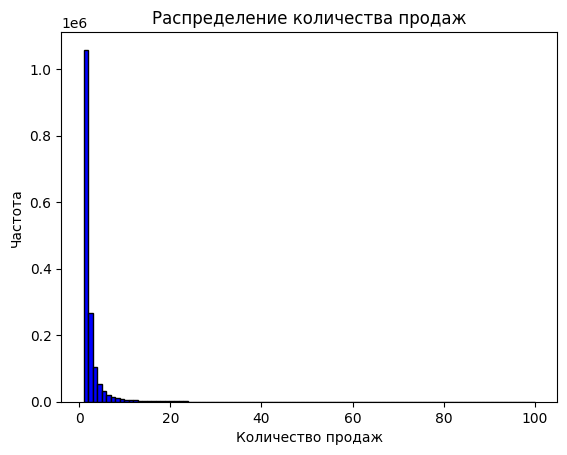

In [ ]:
# # ваш код здесь
# import matplotlib.pyplot as plt
# import seaborn as sns

# matplotlib histogram
plt.hist(sales_train1['item_cnt'], color = 'blue', edgecolor = 'black',bins = int(100))

# Add labels
plt.title('Распределение количества продаж')
plt.xlabel('Количество продаж')
plt.ylabel('Частота')

Проверим на нормальность распределения после логарифмирования

In [ ]:
sales_train1 = sales_train1.copy()
sales_train1['item_cnt_log'] = np.log(sales_train1['item_cnt']+1)

In [ ]:
from scipy import stats
stat, p = stats.normaltest(sales_train1['item_cnt_log'])
alpha = 0.05
print('p-value = ', p)
if p < alpha:  # проверка условия
    print("Данные не распределены нормально (мы отвергаем H0)")
else:
    print("Данные распределены нормально")

p-value =  0.0
Данные не распределены нормально (мы отвергаем H0)


Text(0, 0.5, 'Частота')

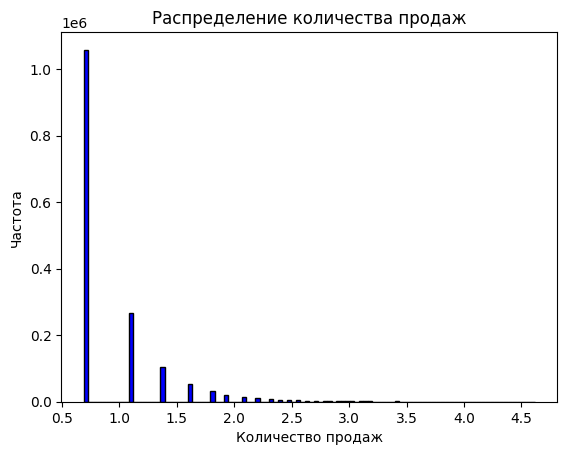

In [ ]:
# matplotlib histogram
plt.hist(sales_train1['item_cnt_log'], color = 'blue', edgecolor = 'black',bins = int(100))

# Add labels
plt.title('Распределение количества продаж')
plt.xlabel('Количество продаж')
plt.ylabel('Частота')

In [ ]:
gp_month_mean = processed_data.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = processed_data.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_season_mean = processed_data.groupby(['season'], as_index=False)['item_cnt'].mean()
gp_season_sum = processed_data.groupby(['season'], as_index=False)['item_cnt'].sum()
gp_category_mean = processed_data.groupby(['category'], as_index=False)['item_cnt'].mean()
gp_category_sum = processed_data.groupby(['category'], as_index=False)['item_cnt'].sum()
# gp_category_mean = processed_data.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
# gp_category_sum = processed_data.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_city_mean = processed_data.groupby(['city'], as_index=False)['item_cnt'].mean()
gp_city_sum = processed_data.groupby(['city'], as_index=False)['item_cnt'].sum()
gp_shop_mean = processed_data.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = processed_data.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

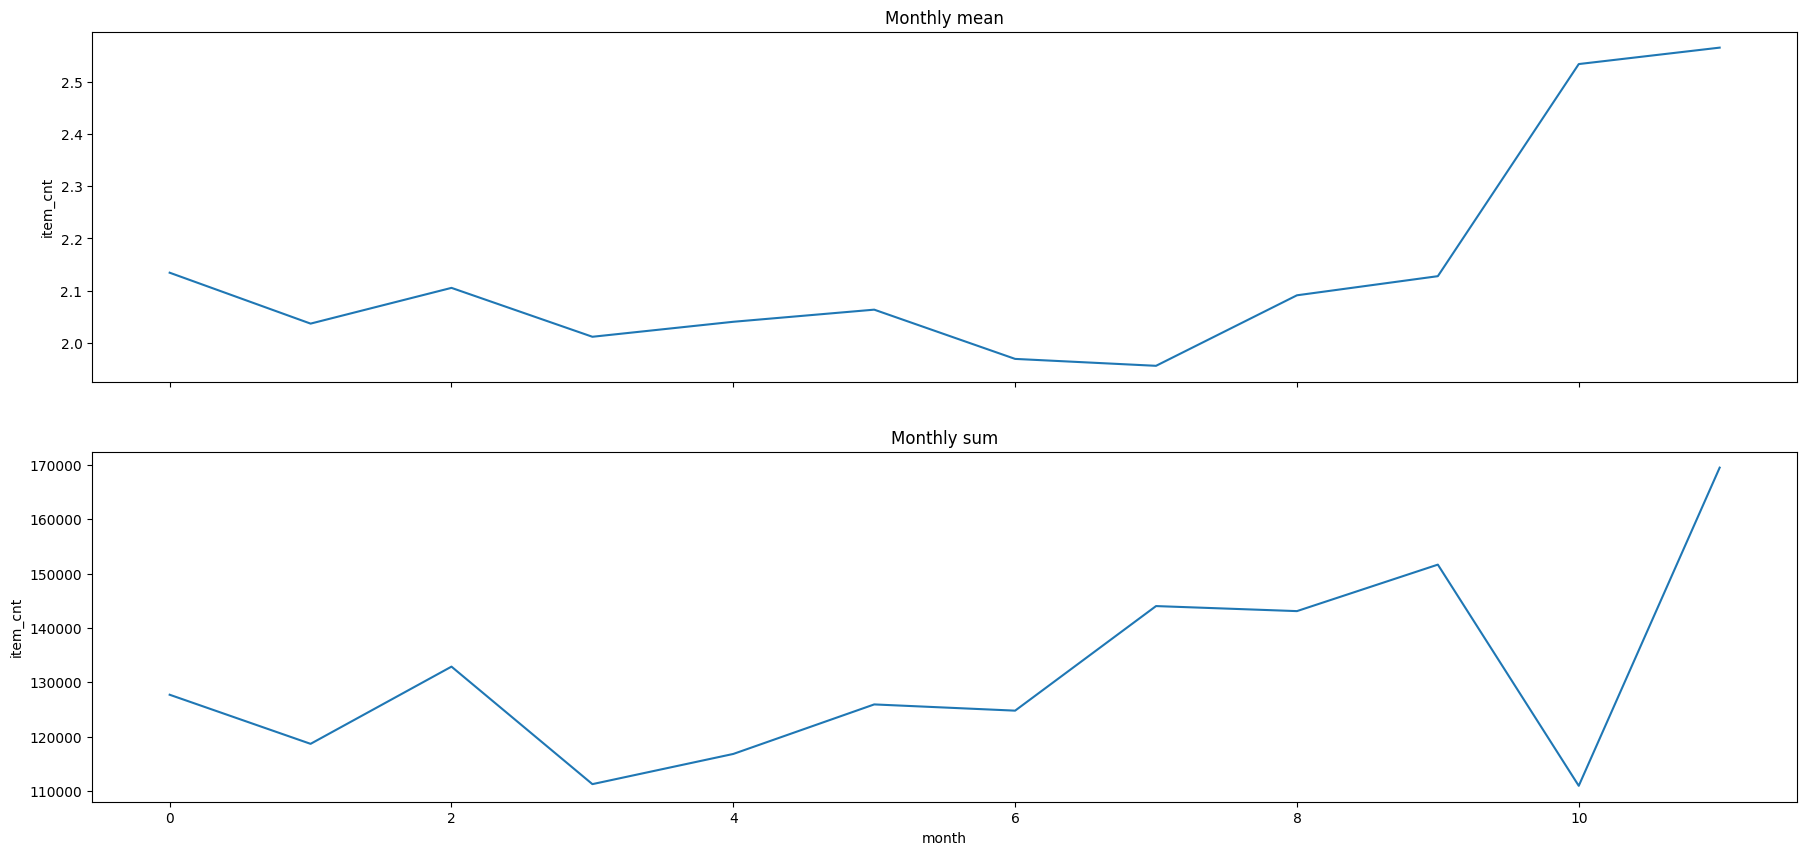

In [ ]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

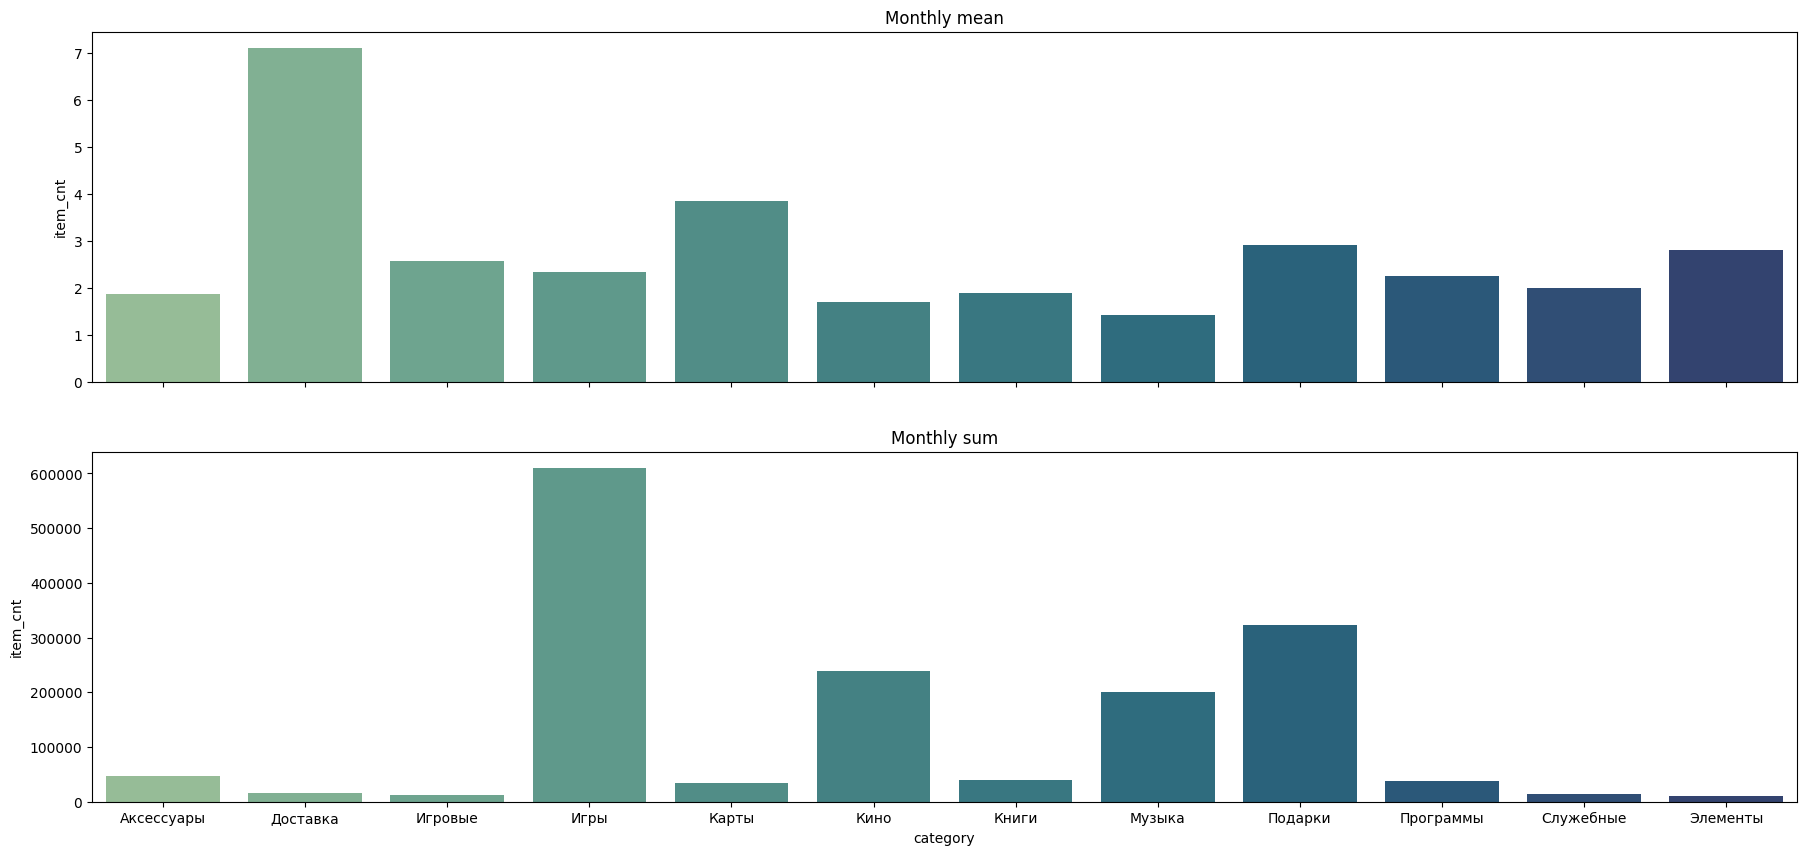

In [ ]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="category", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="crest").set_title("Monthly mean")
sns.barplot(x="category", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="crest").set_title("Monthly sum")
plt.show()


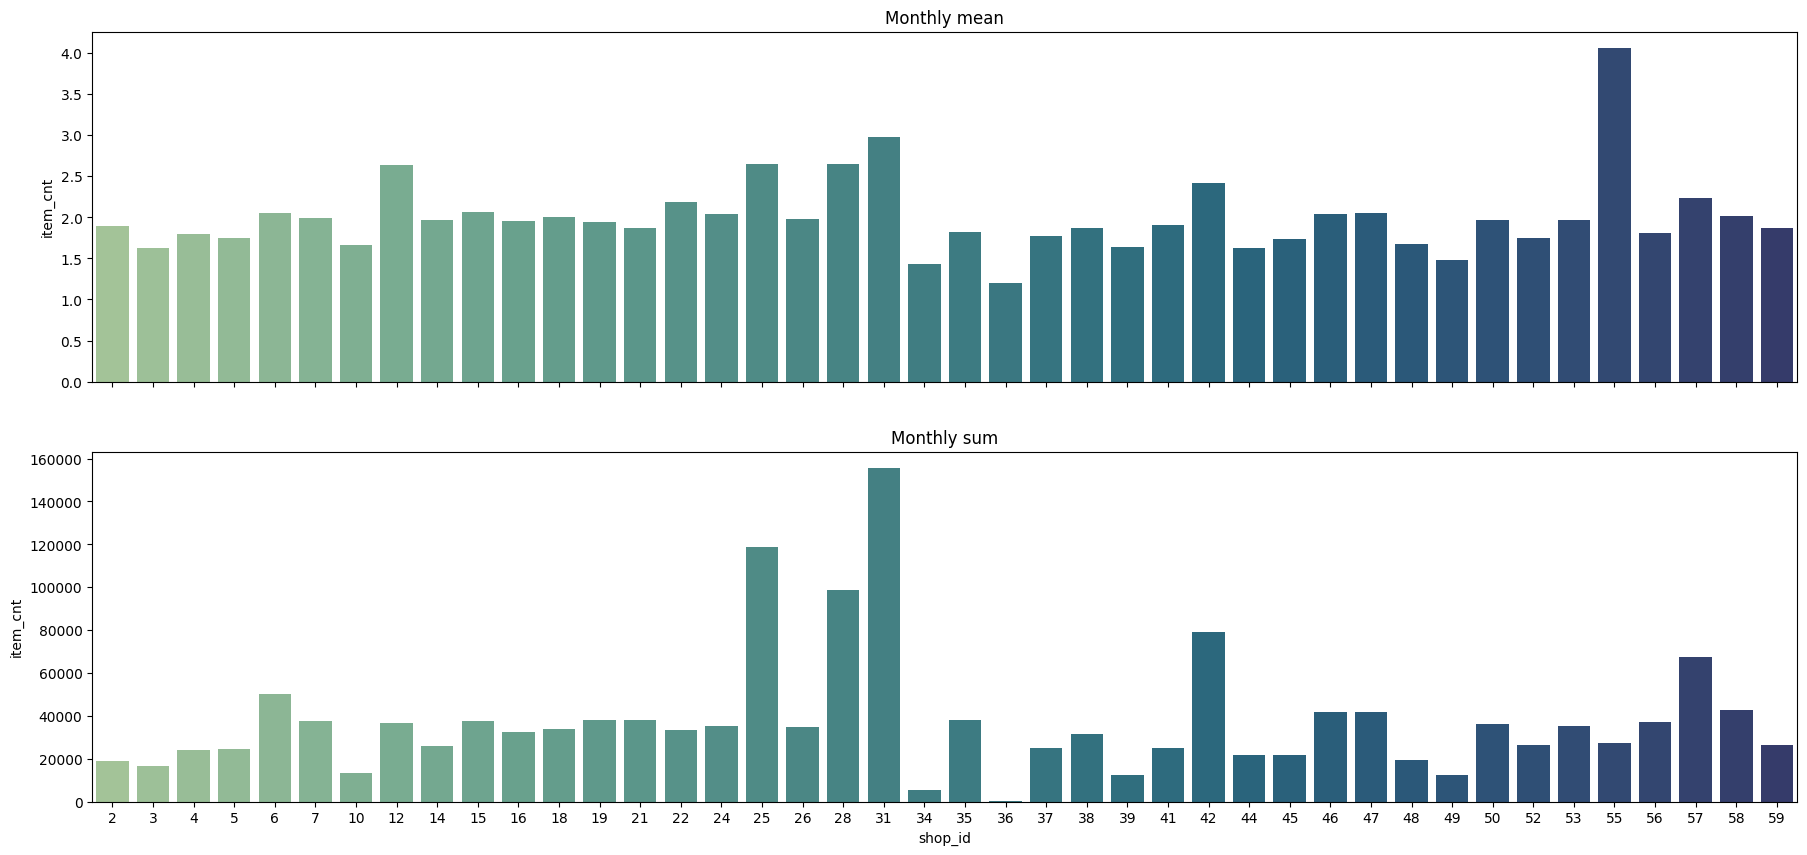

In [ ]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="crest").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="crest").set_title("Monthly sum")
plt.show()

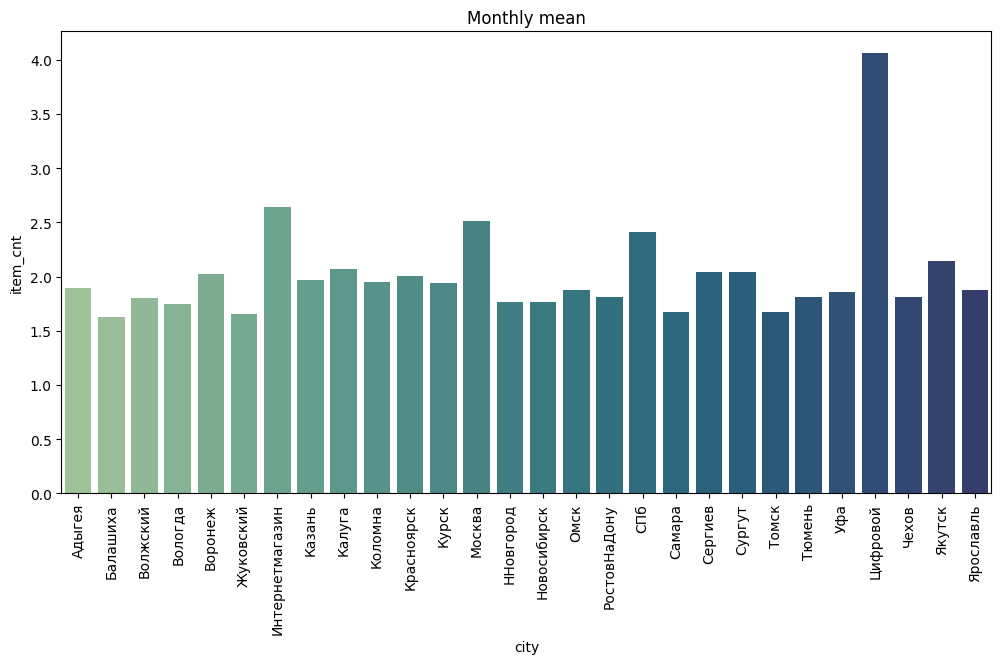

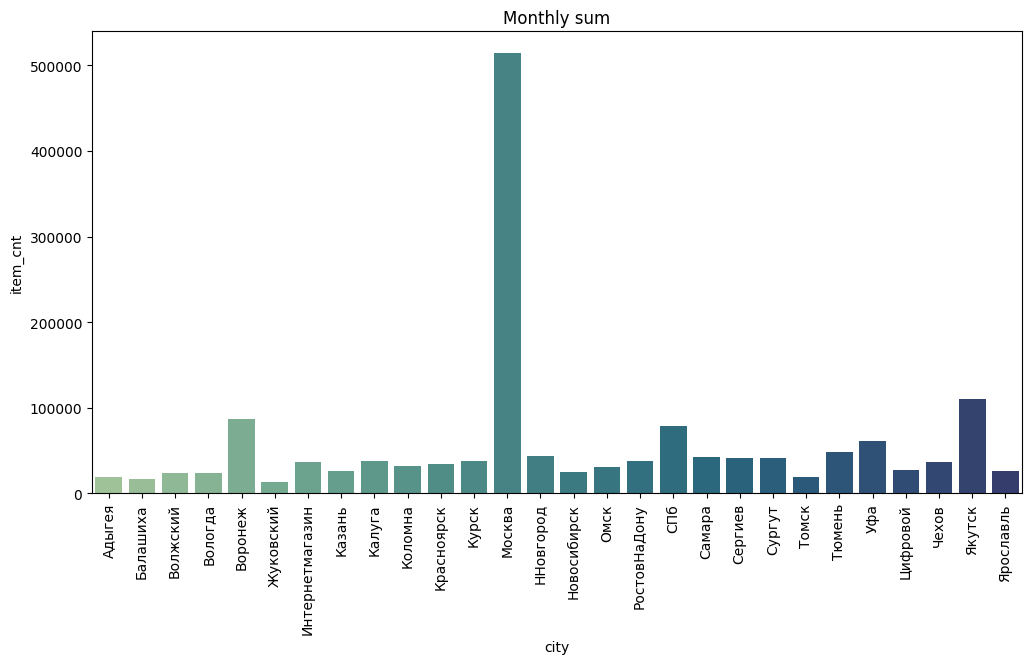

In [ ]:
# Создание графика среднего значения
plt.figure(figsize=(12, 6))
sns.barplot(x="city", y="item_cnt", hue="city", data=gp_city_mean, ax=plt.gca(), palette="crest", legend=False)
plt.title("Monthly mean")
plt.xticks(rotation=90)  # Поворот надписей на оси x на 90 градусов
plt.show()

# Создание графика суммы
plt.figure(figsize=(12, 6))
sns.barplot(x="city", y="item_cnt", hue="city", data=gp_city_sum, ax=plt.gca(), palette="crest", legend=False)
plt.title("Monthly sum")
plt.xticks(rotation=90)  # Поворот надписей на оси x на 90 градусов
plt.show()

# **Работа над выбросами.**
Думаю, этап обработки выбросов должен произойти на самом низком уровне, до агрегаций. Так я предположительно буду рассматривать работу с XGBoost и CatBoost, которые неплохо справляются с выбросами, то я удалю только те наблюдения, которые не входят в интервал 0.001 и 0.999 квантиля по параметру - количество продаж в день.

In [ ]:
def filter_outliers(df, column_names, lower_quantile=0.001, upper_quantile=0.999, groupby_column='item_category_id'):
    """
    Filters outliers from a DataFrame based on quantiles of specified columns within each category.

    Parameters:
    - df: pandas.DataFrame to filter.
    - column_names: List of column names (e.g., ['item_cnt_day', 'item_price']) to apply the outlier filter on.
    - lower_quantile: Lower quantile threshold for filtering (default is 0.001).
    - upper_quantile: Upper quantile threshold for filtering (default is 0.999).
    - groupby_column: Column name to group by before filtering (default is 'category').

    Returns:
    - filtered_df: DataFrame with outliers removed based on the specified columns.
    """
    for column_name in column_names:
        outlier_mask = df.groupby(groupby_column)[column_name].transform(
            lambda x: (x < x.quantile(lower_quantile)) | (x > x.quantile(upper_quantile))
        )
        df = df[~outlier_mask]
    return df

In [ ]:
filtered_train = filter_outliers(processed_data, column_names = ['item_cnt_day'])
print(f'Количество наблюдений после очистки выбросов по количеству сократилось на {len(processed_data) - len(filtered_train)} шт. от всего количества')

Количество наблюдений после очистки выбросов по количеству сократилось на 2621 шт. от всего количества


In [ ]:
filtered_train = filtered_train.sort_values('date')
filtered_train = filtered_train.drop(labels = ['shop_item_id','date'],axis=1)

In [ ]:
df = filtered_train.copy()

In [ ]:
filtered_train.to_csv('filtered_train.csv')

In [ ]:
filtered_train

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,category,city,year,season,month
10623,0,19,13102,1290.00,1,4,Аксессуары,Курск,2013,0,0
100832,0,51,16971,200.00,1,37,Кино,Тюмень,2013,0,0
100833,0,51,16945,76.00,1,40,Кино,Тюмень,2013,0,0
17551,0,27,19129,299.00,1,40,Кино,Москва,2013,0,0
11183,0,19,7081,449.00,1,30,Игры,Курск,2013,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2886764,33,42,13723,229.00,1,69,Подарки,СПб,2015,1,9
2886742,33,42,14525,499.00,1,55,Музыка,СПб,2015,1,9
2886730,33,42,15069,2499.00,1,28,Игры,СПб,2015,1,9
2886680,33,42,14400,299.00,1,37,Кино,СПб,2015,1,9


In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import LabelEncoder

# # Предположим, df - это ваш DataFrame с колонками 'cat' и 'city'

# # Создание и инициализация LabelEncoder
# label_encoder = LabelEncoder()

# # Применение LabelEncoder к каждой колонке
# df['cat_encoded'] = label_encoder.fit_transform(df['category'])
# df['city_encoded'] = label_encoder.fit_transform(df['city'])
# df = df.drop(labels = ['category','city','year','season','month'],axis=1)

In [ ]:
df.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,cat_encoded,city_encoded
10623,0,19,13102,1290.00,1,4,1,12
100832,0,51,16971,200.00,1,37,7,24
100833,0,51,16945,76.00,1,40,7,24
17551,0,27,19129,299.00,1,40,7,13
11183,0,19,7081,449.00,1,30,5,12


In [ ]:
filtered_train.head(2)

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,category,city,year,season,month
10623,0,19,13102,1290.00,1,4,Аксессуары,Курск,2013,0,0
100832,0,51,16971,200.00,1,37,Кино,Тюмень,2013,0,0


In [ ]:

df_pivot_sales_train = df.pivot_table(
        index = ['shop_id','item_id','item_category_id','cat_encoded','city_encoded'],
        columns = 'date_block_num',
        values = 'item_cnt_day',
        aggfunc='sum').fillna(0.0)

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,cat_encoded,city_encoded
10623,0,19,13102,1290.00,1,4,1,12
100832,0,51,16971,200.00,1,37,7,24
100833,0,51,16945,76.00,1,40,7,24
17551,0,27,19129,299.00,1,40,7,13
11183,0,19,7081,449.00,1,30,5,12


In [ ]:
df_pivot_sales_train.head()

date_block_num                                              0     1    2   \
shop_id item_id item_category_id cat_encoded city_encoded                   
0       30      40               7           29           0.00 22.00 0.00   
        31      37               7           29           0.00 11.00 0.00   
        32      40               7           29           6.00 10.00 0.00   
        33      37               7           29           3.00  3.00 0.00   
        35      40               7           29           1.00 14.00 0.00   

date_block_num                                              3    4    5    6   \
shop_id item_id item_category_id cat_encoded city_encoded                       
0       30      40               7           29           0.00 0.00 0.00 0.00   
        31      37               7           29           0.00 0.00 0.00 0.00   
        32      40               7           29           0.00 0.00 0.00 0.00   
        33      37               7           29           0.00 0.00 0.00 0.00   
        35      40               7           29           0.00 0.00 0.00 0.00   

date_block_num                                              7    8    9   ...  \
shop_id item_id item_category_id cat_encoded city_encoded                 ...   
0       30      40               7           29           0.00 0.00 0.00  ...   
        31      37               7           29           0.00 0.00 0.00  ...   
        32      40               7           29           0.00 0.00 0.00  ...   
        33      37               7           29           0.00 0.00 0.00  ...   
        35      40               7           29           0.00 0.00 0.00  ...   

date_block_num                                              24   25   26   27  \
shop_id item_id item_category_id cat_encoded city_encoded                       
0       30      40               7           29           0.00 0.00 0.00 0.00   
        31      37               7           29           0.00 0.00 0.00 0.00   
        32      40               7           29           0.00 0.00 0.00 0.00   
        33      37               7           29           0.00 0.00 0.00 0.00   
        35      40               7           29           0.00 0.00 0.00 0.00   

date_block_num                                              28   29   30   31  \
shop_id item_id item_category_id cat_encoded city_encoded                       
0       30      40               7           29           0.00 0.00 0.00 0.00   
        31      37               7           29           0.00 0.00 0.00 0.00   
        32      40               7           29           0.00 0.00 0.00 0.00   
        33      37               7           29           0.00 0.00 0.00 0.00   
        35      40               7           29           0.00 0.00 0.00 0.00   

date_block_num                                              32   33  
shop_id item_id item_category_id cat_encoded city_encoded            
0       30      40               7           29           0.00 0.00  
        31      37               7           29           0.00 0.00  
        32      40               7           29           0.00 0.00  
        33      37               7           29           0.00 0.00  
        35      40               7           29           0.00 0.00  

[5 rows x 34 columns]

In [ ]:
df_pivot_sales_train= df_pivot_sales_train.reset_index()
df_pivot_sales_train.head()

date_block_num,index,shop_id,item_id,item_category_id,cat_encoded,city_encoded,0,1,2,3,...,24,25,26,27,28,29,30,31,32,33
0,0,0,30,40,7,29,0.00,22.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1,0,31,37,7,29,0.00,11.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2,0,32,40,7,29,6.00,10.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,3,0,33,37,7,29,3.00,3.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,4,0,35,40,7,29,1.00,14.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
df_pivot_sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424101 entries, 0 to 424100
Data columns (total 40 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   index             424101 non-null  int64  
 1   shop_id           424101 non-null  int64  
 2   item_id           424101 non-null  int64  
 3   item_category_id  424101 non-null  int64  
 4   cat_encoded       424101 non-null  int64  
 5   city_encoded      424101 non-null  int64  
 6   0                 424101 non-null  float64
 7   1                 424101 non-null  float64
 8   2                 424101 non-null  float64
 9   3                 424101 non-null  float64
 10  4                 424101 non-null  float64
 11  5                 424101 non-null  float64
 12  6                 424101 non-null  float64
 13  7                 424101 non-null  float64
 14  8                 424101 non-null  float64
 15  9                 424101 non-null  float64
 16  10                42

In [ ]:
df_pivot_sales_train = df_pivot_sales_train[['shop_id','item_id','item_category_id','cat_encoded','city_encoded'] + list(range(34))]
df_pivot_sales_train.head(3)

date_block_num,shop_id,item_id,item_category_id,cat_encoded,city_encoded,0,1,2,3,4,...,24,25,26,27,28,29,30,31,32,33
0,0,30,40,7,29,0.00,22.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0,31,37,7,29,0.00,11.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0,32,40,7,29,6.00,10.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
df_pivot_sales_train.to_csv('df_pivot_sales_train.csv')

In [ ]:
# df_pivot_sales_train = df_pivot_sales_train1.copy()

In [ ]:
#Use XGBoost ML Model for prediction

#Define Hyper parameter values

param = {'max_depth':10,
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3,
         'num_round':1000,
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

progress = dict()

xgbtrain = xgb.DMatrix(
    df_pivot_sales_train.iloc[:,  (df_pivot_sales_train.columns != 33)].values,
    df_pivot_sales_train.iloc[:, df_pivot_sales_train.columns == 33].values)

watchlist  = [(xgbtrain,'train-rmse')]

bst = xgb.train(param, xgbtrain)

#Prediction Model
preds = bst.predict(xgb.DMatrix(df_pivot_sales_train.iloc[:,  (df_pivot_sales_train.columns != 33)].values))

rmse = np.sqrt(mean_squared_error(preds,df_pivot_sales_train.iloc[:, df_pivot_sales_train.columns == 33].values))
print(f"Root Mean Squared Error: {rmse}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [10:27:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_round", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Root Mean Squared Error: 0.7843860896036939


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

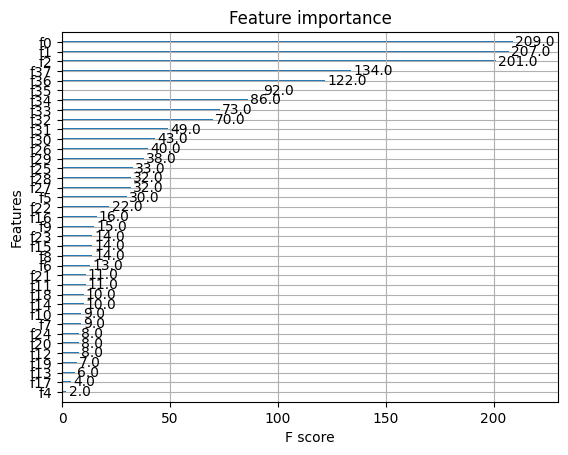

In [ ]:
xgb.plot_importance(bst)

In [ ]:
# # Group by month in this case "date_block_num" and aggregate features.
# train_monthly = filtered_train.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
# train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# # Rename features.
# train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

# **ВТОРОЙ ВАРИАНТ**

In [ ]:
# Мы берем датасет сразу после удаления выбросов, и фильтруем его так, чтобы в датасете были только те магазины и товары, которые есть в тесте
# На этот раз мы рассматриваем задачу как Time Series Prediction и подход будет другим
df = pd.read_csv("/content/filtered_train (1).csv",index_col=0,parse_dates=['date'])

In [ ]:
# df = df.sort_values('date')
# Удаляем сгенерированные признаки по метке времени и городу - этот этап будет после агрегации
# df = df.drop(labels = ['year','season',	'month', 'shop_item_id','category','city'], axis = 1)
lk_train = df.drop(labels = ['year','season',	'month'], axis = 1)
lk_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,shop_item_id,category,city
0,2013-02-01,0,59,22154,999.00,1,37,59-22154,Кино,Ярославль
1,2013-03-01,0,25,2552,899.00,1,58,25-2552,Музыка,Москва
2,2013-05-01,0,25,2552,899.00,-1,58,25-2552,Музыка,Москва
3,2013-06-01,0,25,2554,1709.05,1,58,25-2554,Музыка,Москва
4,2013-01-15,0,25,2555,1099.00,1,56,25-2555,Музыка,Москва


In [ ]:
# Сгруппируем данные по месяцам
print(len(lk_train))
# Сгруппируем данные по месяцам
# train_monthly = lk_train.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = lk_train.sort_values('date').groupby(['date_block_num', 'shop_id','city','category', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'city','category','item_category_id', 'item_id', 'sum_item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'col_transactions']
print(len(train_monthly))

2933228
1608964


In [ ]:
train_monthly

,date_block_num,shop_id,city,category,item_category_id,item_id,sum_item_price,mean_item_price,item_cnt,mean_item_cnt,col_transactions
0,0,0,Якутск,Аксессуары,2,5572,7932.00,1322.00,10,1.67,6
1,0,0,Якутск,Аксессуары,2,5573,560.00,560.00,1,1.00,1
2,0,0,Якутск,Аксессуары,2,5575,2418.00,806.00,4,1.33,3
3,0,0,Якутск,Аксессуары,2,5576,11155.00,2231.00,5,1.00,5
4,0,0,Якутск,Аксессуары,2,5609,2381.00,2381.00,1,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...
1608959,33,59,Ярославль,Программы,75,5383,4390.00,4390.00,1,1.00,1
1608960,33,59,Ярославль,Служебные,79,17717,8025.50,802.55,13,1.30,10
1608961,33,59,Ярославль,Элементы,83,22087,357.00,119.00,6,2.00,3
1608962,33,59,Ярославль,Элементы,83,22088,238.00,119.00,2,1.00,2


In [ ]:
sales_train = train_monthly.copy()
def calculate_mean_sales(data):
    # Рассчитываем среднюю 'item_cnt' в группе ['shop_id', 'item_id']
    data['shop_item_cnt_mean'] = data.groupby(['shop_id', 'item_id'])['item_cnt'].transform('mean')

    # Рассчитываем среднюю 'item_cnt' в группе ['shop_id', 'item_category_id']
    data['shop_item_category_id_cnt_mean'] = data.groupby(['shop_id', 'item_category_id'])['item_cnt'].transform('mean')

    # Рассчитываем среднюю 'item_cnt' в группе ['shop_id', 'item_category']
    data['shop_item_category_cnt_mean'] = data.groupby(['shop_id', 'category'])['item_cnt'].transform('mean')

    # Рассчитываем среднюю 'item_cnt' в группе ['sity', 'item_id']
    data['sity_item_id_cnt_mean'] = data.groupby(['city', 'item_id'])['item_cnt'].transform('mean')

    # Рассчитываем среднюю 'item_cnt' в группе ['sity', 'item_category_id']
    data['sity_category_id_cnt_mean'] = data.groupby(['city', 'item_category_id'])['item_cnt'].transform('mean')

    # Рассчитываем среднюю 'item_cnt' в группе ['sity', 'item_category']
    data['sity_item_category_cnt_mean'] = data.groupby(['city', 'category'])['item_cnt'].transform('mean')

    return data

# Применяем функцию к DataFrame sales_train
sales_train = calculate_mean_sales(sales_train)
sales_train.head(15)

,date_block_num,shop_id,city,category,item_category_id,item_id,sum_item_price,mean_item_price,item_cnt,mean_item_cnt,col_transactions,shop_item_cnt_mean,shop_item_category_id_cnt_mean,shop_item_category_cnt_mean,sity_item_id_cnt_mean,sity_category_id_cnt_mean,sity_item_category_cnt_mean
0,0,0,Якутск,Аксессуары,2,5572,7932.00,1322.00,10,1.67,6,10.50,2.84,4.14,2.95,2.04,2.74
1,0,0,Якутск,Аксессуары,2,5573,560.00,560.00,1,1.00,1,1.00,2.84,4.14,1.24,2.04,2.74
2,0,0,Якутск,Аксессуары,2,5575,2418.00,806.00,4,1.33,3,4.00,2.84,4.14,1.50,2.04,2.74
3,0,0,Якутск,Аксессуары,2,5576,11155.00,2231.00,5,1.00,5,3.50,2.84,4.14,2.17,2.04,2.74
4,0,0,Якутск,Аксессуары,2,5609,2381.00,2381.00,1,1.00,1,1.00,2.84,4.14,1.00,2.04,2.74
5,0,0,Якутск,Аксессуары,2,5612,3623.00,3623.00,1,1.00,1,1.00,2.84,4.14,1.36,2.04,2.74
6,0,0,Якутск,Аксессуары,2,5623,294.00,294.00,1,1.00,1,2.00,2.84,4.14,2.00,2.04,2.74
7,0,0,Якутск,Аксессуары,2,5627,4120.00,2060.00,2,1.00,2,3.00,2.84,4.14,2.67,2.04,2.74
8,0,0,Якутск,Аксессуары,2,5629,15400.00,1925.00,9,1.12,8,7.00,2.84,4.14,2.50,2.04,2.74
9,0,0,Якутск,Аксессуары,2,5630,2060.00,2060.00,1,1.00,1,1.00,2.84,4.14,1.00,2.04,2.74


In [ ]:
sales_train.columns

Index(['date_block_num', 'shop_id', 'city', 'category', 'item_category_id',
       'item_id', 'sum_item_price', 'mean_item_price', 'item_cnt',
       'mean_item_cnt', 'col_transactions', 'shop_item_cnt_mean',
       'shop_item_category_id_cnt_mean', 'shop_item_category_cnt_mean',
       'sity_item_id_cnt_mean', 'sity_category_id_cnt_mean',
       'sity_item_category_cnt_mean'],
      dtype='object')

# **РЕШАЕМ ЗАДАЧУ КАК ЗАДАЧУ РЕГРЕСИИ**

Создадим признаки из метки времени

In [ ]:
def add_datetime_features(data):
    data['year'] = data['date_block_num'].apply(lambda x: ((x//12) + 2013))
    data['season'] = data['date_block_num'].apply(lambda x: (x % 4))
    data['month'] = data['date_block_num'].apply(lambda x: (x % 12))
    return data

sales_train = add_datetime_features(sales_train)


Кодировка признаков
one_hot_encoder - объект класса OneHotEncoder
data_onehot - numpy-массив, полученный в результате трансформации кодировщиком
В результате выполнения задания у вас должен быть образован DataFrame data_onehot, который содержит кодированные категориальные признаки

In [ ]:
columns_to_change = ['city', 'category']
encoder = preprocessing.OneHotEncoder(drop='first')
data_onehot = encoder.fit_transform(sales_train[['city', 'category']]).toarray()
column_names = encoder.get_feature_names_out(columns_to_change)
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
print(f'Получилось сгенерировать с помощью однократного кодирования {len(data_onehot.axes[1])} бинарных столбцов')

Получилось сгенерировать с помощью однократного кодирования 44 бинарных столбцов


Добавим полученную таблицу с закодированными признаками:

In [ ]:
train_data = pd.concat(
    [sales_train.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot],
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1608964, 62)


ки? Какой тип валидации выбрать? Перемешивать ли данные во время train_test_split или просто брать кусок последних наблюдений?
ChatGPT
Да, вы можете рассматривать эту задачу не только как Time Series Prediction, но и как задачу регрессии, используя XGBoost или любой другой алгоритм машинного обучения. Это подходит в случаях, когда у вас есть дополнительные признаки, помимо временной метки, которые могут помочь предсказать целевую переменную. В вашем случае, когда данные содержат информацию о магазинах, товарах, категориях и другие, использование регрессии может быть вполне оправданным.

Разделение данных на тренировочную и валидационную выборки
При работе с временными рядами обычно предпочтительнее использовать метод разделения данных, который учитывает временную структуру данных. Это означает, что вы не должны перемешивать данные перед разделением, поскольку это нарушит временную последовательность и может привести к "утечке" информации из будущего в прошлое.

Один из подходов — использовать первые 32 месяца для тренировки и 33-й месяц для валидации. Этот метод позволяет модели учиться на данных, которые предшествуют валидационному набору, и тем самым проверять, насколько хорошо модель обобщает на данных, которые она не видела.

Тип валидации
Временной раздел: Разделите данные на тренировочный и валидационный наборы, используя временной порог. Например, используйте данные до 32-го месяца включительно для тренировки и данные 33-го месяца для валидации.

Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака

In [ ]:
sales_train = train_data.copy()

In [ ]:
from sklearn.model_selection import train_test_split

# Предполагаем, что `sales_train` отсортирован по времени
# Определяем индекс, по которому будем разделять данные
split_index = int(len(sales_train) * 0.9)  # Например, 90% данных для тренировки

# Разделение данных без перемешивания
X_train, X_val = sales_train.iloc[:split_index, :-1], sales_train.iloc[split_index:, :-1]
y_train, y_val = sales_train.iloc[:split_index, -1], sales_train.iloc[split_index:, -1]

# Или используя дату
# Предположим, что 'date_block_num' = 34 для валидации
X_train = sales_train[sales_train['date_block_num'] < 33].drop(columns=['item_cnt'])
y_train = sales_train[sales_train['date_block_num'] < 33]['item_cnt']
X_val = sales_train[sales_train['date_block_num'] == 33].drop(columns=['item_cnt'])
y_val = sales_train[sales_train['date_block_num'] == 33]['item_cnt']
print(len(X_train))
print(len(X_val))

1577438
31526


In [ ]:
sales_train[sales_train['date_block_num'] == 33]['item_cnt'].max()

461

In [ ]:
from sklearn import feature_selection
selector = feature_selection.SelectKBest(feature_selection.f_regression, k=25)
selector.fit(X_train, y_train)

best_features = selector.get_feature_names_out()
X_train = X_train[best_features]
X_val = X_val[best_features]

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1577438 entries, 0 to 1577437
Data columns (total 25 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   item_category_id                1577438 non-null  int64  
 1   sum_item_price                  1577438 non-null  float64
 2   mean_item_price                 1577438 non-null  float64
 3   mean_item_cnt                   1577438 non-null  float64
 4   col_transactions                1577438 non-null  int64  
 5   shop_item_cnt_mean              1577438 non-null  float64
 6   shop_item_category_id_cnt_mean  1577438 non-null  float64
 7   shop_item_category_cnt_mean     1577438 non-null  float64
 8   sity_item_id_cnt_mean           1577438 non-null  float64
 9   sity_category_id_cnt_mean       1577438 non-null  float64
 10  sity_item_category_cnt_mean     1577438 non-null  float64
 11  month                           1577438 non-null  int64  
 12  

In [ ]:

scaler = preprocessing.MinMaxScaler()
# columns = X_train.columns
X_train = scaler.fit_transform(X_train)
X_train_scaled = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_val_scaled = scaler.transform(X_val)



# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn import ensemble
from sklearn import metrics
grad_boost = ensemble.GradientBoostingRegressor(learning_rate=0.5,
                                n_estimators=10,
                                max_depth=6,
                                min_samples_split=20,
                                random_state=42)
grad_boost.fit(X_train, y_train)
y_train_pred = grad_boost.predict(X_train)
y_valid_pred = grad_boost.predict(X_val)
print('метрика RMSLE на тренировочной выборке для модели градиентного бустинга: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))))
print('метрика RMSLE на валидационной выборке для модели градиентного бустинга: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_val, y_valid_pred))))

метрика RMSLE на тренировочной выборке для модели градиентного бустинга: 0.29
метрика RMSLE на валидационной выборке для модели градиентного бустинга: 1108.97


Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно
1.1. добавить колонку 'date_block_num' со значением 34

1. Добавить новые признаки (временные и категориальные и географические с помощью нашего класса)

2. Добавить признаки средних значений уровня продаж в зависимости от подкатегории,категории, местоположения магазина и проч.;

2. Произвести кодировку категориальных признаков:
Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;

3. Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;

4. Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Predict Future Sales/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32','item_id': 'int32'})

In [ ]:
df_test['date_block_num'] = 34
df_test

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34
...,...,...,...,...
214195,214195,45,18454,34
214196,214196,45,16188,34
214197,214197,45,15757,34
214198,214198,45,19648,34


In [ ]:
# data = train_monthly.copy()
# Создаем экземпляр класса DataProcessor
processor = DataProcessor(df_cities, df_category)
# Обрабатываем данные с помощью метода process_data
processed_test_data = processor.process_data(df_test)

In [ ]:
processed_test_data

,ID,shop_id,item_id,date_block_num,item_category_id,category,city,year,season,month
0,0,5,5037,34,19,Игры,Вологда,2015,2,10
1,1,5,5320,34,55,Музыка,Вологда,2015,2,10
2,2,5,5233,34,19,Игры,Вологда,2015,2,10
3,3,5,5232,34,23,Игры,Вологда,2015,2,10
4,4,5,5268,34,20,Игры,Вологда,2015,2,10
...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,55,Музыка,Самара,2015,2,10
214196,214196,45,16188,34,64,Подарки,Самара,2015,2,10
214197,214197,45,15757,34,55,Музыка,Самара,2015,2,10
214198,214198,45,19648,34,40,Кино,Самара,2015,2,10


In [ ]:
# Слияние таблиц по сцепке 'shop_id' - 'item_id'
merged_data = pd.merge(processed_test_data, sales_train[['shop_id', 'item_id', 'shop_item_cnt_mean',
                                                         'shop_item_category_id_cnt_mean',
                                                         'shop_item_category_cnt_mean',
                                                         'sity_item_id_cnt_mean',
                                                         'sity_category_id_cnt_mean',
                                                         'sity_item_category_cnt_mean']],
                       on=['shop_id', 'item_id'], how='left')

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 702901 entries, 0 to 702900
Data columns (total 16 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              702901 non-null  int32  
 1   shop_id                         702901 non-null  int32  
 2   item_id                         702901 non-null  int32  
 3   date_block_num                  702901 non-null  int64  
 4   item_category_id                702901 non-null  int32  
 5   category                        702901 non-null  object 
 6   city                            702901 non-null  object 
 7   year                            702901 non-null  int64  
 8   season                          702901 non-null  int64  
 9   month                           702901 non-null  int64  
 10  shop_item_cnt_mean              600098 non-null  float64
 11  shop_item_category_id_cnt_mean  600098 non-null  float64
 12  shop_item_catego

In [ ]:
# # Заполнение пропущенных значений средними значениями по сцепке 'shop_id' - 'item_category_id'
# merged_data.update(pd.merge(processed_test_data, sales_train[['shop_id', 'item_category_id',
#                                                              'shop_item_cnt_mean',
#                                                              'shop_item_category_id_cnt_mean',
#                                                              'shop_item_category_cnt_mean',
#                                                              'sity_item_id_cnt_mean',
#                                                              'sity_category_id_cnt_mean',
#                                                              'sity_item_category_cnt_mean']],
#                             on=['shop_id', 'item_category_id'], how='left',
#                             suffixes=('_x', '_y')).set_index(['ID'])['shop_item_category_id_cnt_mean_y'])
# merged_data.info()

In [ ]:
# # Слияние таблиц по сцепке 'shop_id' - 'item_id'
# merged_data = pd.merge(processed_test_data, sales_train[['shop_id', 'item_id', 'shop_item_cnt_mean',
#                                                          'shop_item_category_id_cnt_mean',
#                                                          'shop_item_category_cnt_mean',
#                                                          'sity_item_id_cnt_mean',
#                                                          'sity_category_id_cnt_mean',
#                                                          'sity_item_category_cnt_mean']],
#                        on=['shop_id', 'item_id'], how='left')

# # Заполнение пропущенных значений средними значениями по сцепке 'shop_id' - 'item_category_id'
# merged_data.update(pd.merge(processed_test_data, sales_train[['shop_id', 'item_category_id',
#                                                              'shop_item_cnt_mean',
#                                                              'shop_item_category_id_cnt_mean',
#                                                              'shop_item_category_cnt_mean',
#                                                              'sity_item_id_cnt_mean',
#                                                              'sity_category_id_cnt_mean',
#                                                              'sity_item_category_cnt_mean']],
#                             on=['shop_id', 'item_category_id'], how='left',
#                             suffixes=('_x', '_y')).set_index(['ID'])['shop_item_category_id_cnt_mean_y'])

# # Заполнение пропущенных значений средними значениями по сцепке 'shop_id' - 'category'
# merged_data.update(pd.merge(processed_test_data, sales_train[['shop_id', 'category',
#                                                              'shop_item_cnt_mean',
#                                                              'shop_item_category_id_cnt_mean',
#                                                              'shop_item_category_cnt_mean',
#                                                              'sity_item_id_cnt_mean',
#                                                              'sity_category_id_cnt_mean',
#                                                              'sity_item_category_cnt_mean']],
#                             on=['shop_id', 'category'], how='left',
#                             suffixes=('_x', '_y')).set_index(['ID'])['shop_item_category_cnt_mean_y'])

# # Заполнение пропущенных значений средними значениями по сцепке 'city' - 'item_category_id'
# merged_data.update(pd.merge(processed_test_data, sales_train[['city', 'item_category_id',
#                                                              'shop_item_cnt_mean',
#                                                              'shop_item_category_id_cnt_mean',
#                                                              'shop_item_category_cnt_mean',
#                                                              'sity_item_id_cnt_mean',
#                                                              'sity_category_id_cnt_mean',
#                                                              'sity_item_category_cnt_mean']],
#                             on=['city', 'item_category_id'], how='left',
#                             suffixes=('_x', '_y')).set_index(['ID'])['shop_item_category_id_cnt_mean_y'])

# # Заполнение пропущенных значений средними значениями по сцепке 'city' - 'category'
# merged_data.update(pd.merge(processed_test_data, sales_train[['city', 'category',
#                                                              'shop_item_cnt_mean',
#                                                              'shop_item_category_id_cnt_mean',
#                                                              'shop_item_category_cnt_mean',
#                                                              'sity_item_id_cnt_mean',
#                                                              'sity_category_id_cnt_mean',
#                                                              'sity_item_category_cnt_mean']],
#                             on=['city', 'category'], how='left',
#                             suffixes=('_x', '_y')).set_index(['ID'])['shop_item_category_cnt_mean_y'])

# # Оставляем только нужные столбцы
# merged_data = merged_data[['shop_item_cnt_mean', 'shop_item_category_id_cnt_mean',
#                            'shop_item_category_cnt_mean', 'sity_item_id_cnt_mean',
#                            'sity_category_id_cnt_mean', 'sity_item_category_cnt_mean']]

# # Выводим результат
# print(merged_data)

Index(['ID', 'shop_id', 'item_id', 'date_block_num', 'category', 'city',
       'year', 'season', 'month'],
      dtype='object')

XGBoost
В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

XGBoost - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.

Для ее использования необходимо для начала установить пакет xgboost:

In [ ]:
import xgboost as xgb

In [ ]:
from sklearn.model_selection import train_test_split

# Предполагаем, что `sales_train` отсортирован по времени
# Определяем индекс, по которому будем разделять данные
split_index = int(len(sales_train) * 0.9)  # Например, 90% данных для тренировки

# Разделение данных без перемешивания
X_train, X_val = sales_train.iloc[:split_index, :-1], sales_train.iloc[split_index:, :-1]
y_train, y_val = sales_train.iloc[:split_index, -1], sales_train.iloc[split_index:, -1]

# Или используя дату
# Предположим, что 'date_block_num' = 34 для валидации
X_train = sales_train[sales_train['date_block_num'] < 33].drop(columns=['item_cnt'])
y_train = sales_train[sales_train['date_block_num'] < 33]['item_cnt']
X_val = sales_train[sales_train['date_block_num'] == 33].drop(columns=['item_cnt'])
y_val = sales_train[sales_train['date_block_num'] == 33]['item_cnt']
print(len(X_train))
print(len(X_val))
scaler = preprocessing.MinMaxScaler()
# columns = X_train.columns
X_train = scaler.fit_transform(X_train)
X_train_scaled = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_val_scaled = scaler.transform(X_val)

1577438
31526


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
feature_names = list(sales_train.drop(columns=['item_cnt']).columns)


In [ ]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train, feature_names=feature_names)
dvalid = xgb.DMatrix(X_val_scaled, label=y_val, feature_names=feature_names)
# dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

In [ ]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9,
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1,
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=5, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:6.82911	valid-rmse:5.39729
[10]	train-rmse:3.48934	valid-rmse:2.01000
[20]	train-rmse:2.49197	valid-rmse:1.72824
[22]	train-rmse:2.40267	valid-rmse:1.79977


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

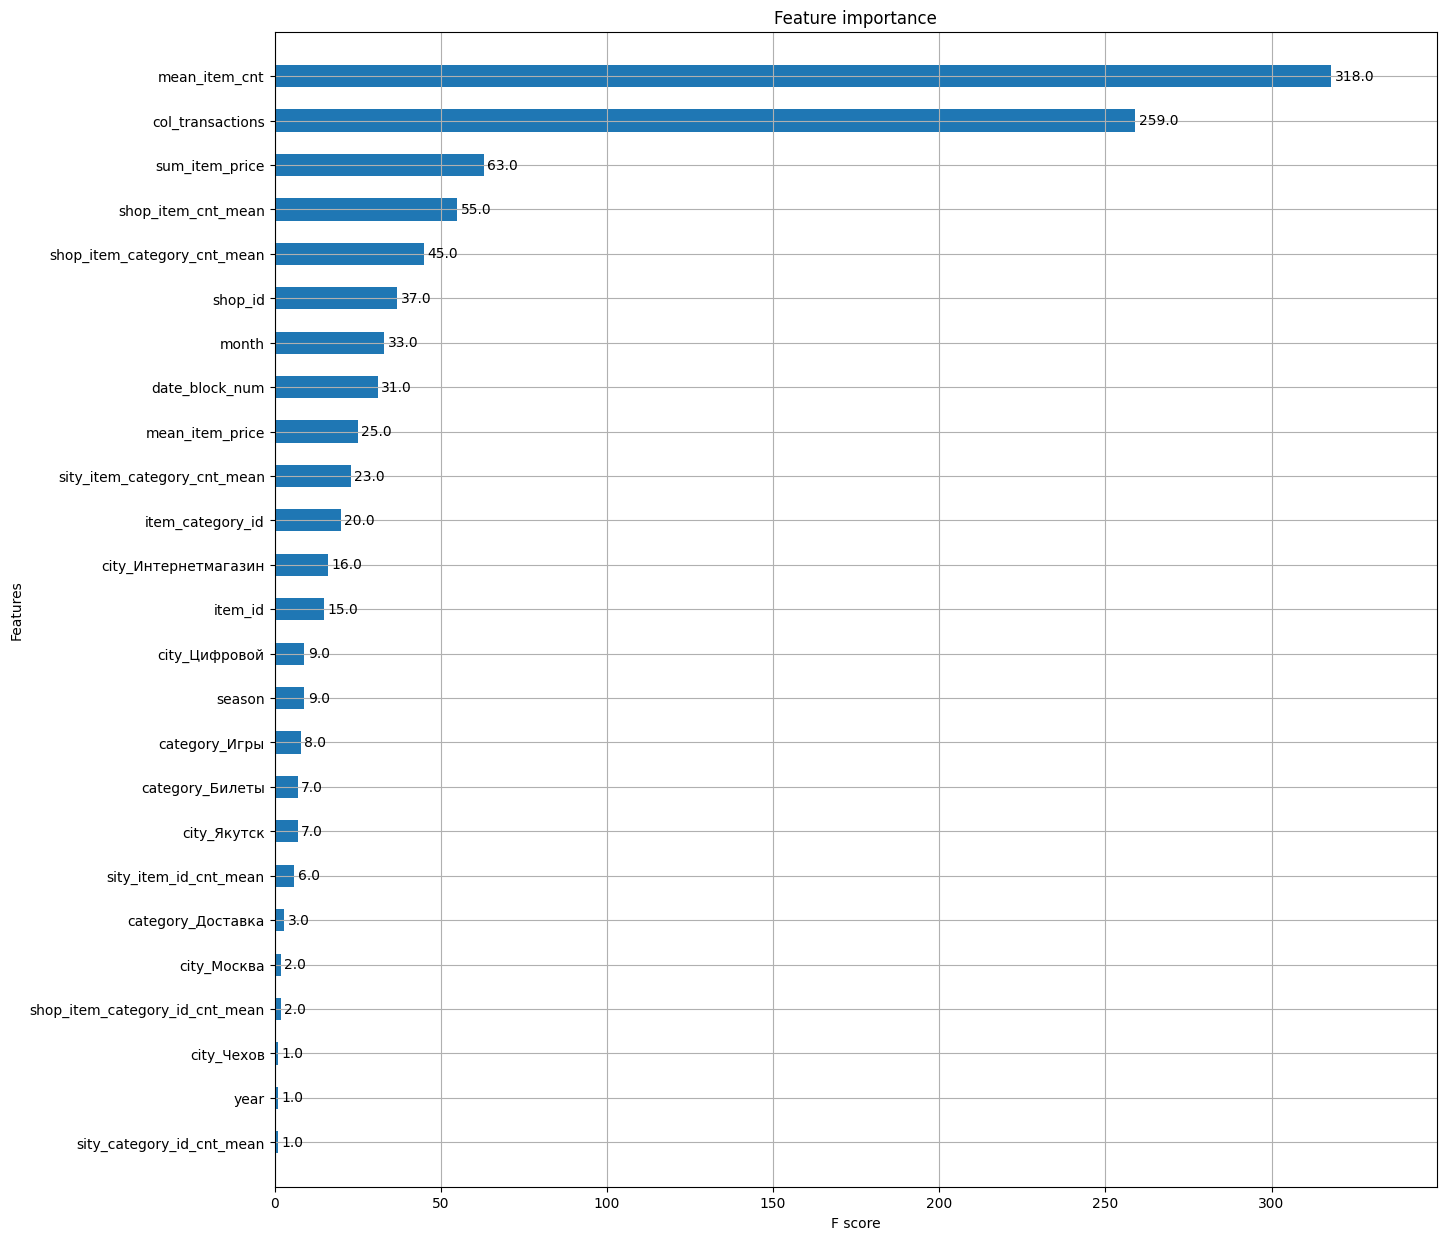

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)

# Попробуем добавить в модель все лаги

In [65]:
df

,date_block_num,shop_id,item_category_id,item_id,item_category_name,shop_name,item_price_mean,item_cnt,price_change,year,season,month,shop_item_cnt_mean,shop_item_category_id_cnt_mean,shop_item_category_cnt_mean,sity_item_id_cnt_mean,sity_category_id_cnt_mean,sity_item_category_cnt_mean
0,0,0,2,5572,1,29,1322.00,7,0,2013,0,0,7.50,2.68,4.04,2.74,1.94,2.64
1,0,0,2,5573,1,29,560.00,1,0,2013,0,0,1.00,2.68,4.04,1.24,1.94,2.64
2,0,0,2,5575,1,29,806.00,4,0,2013,0,0,4.00,2.68,4.04,1.50,1.94,2.64
3,0,0,2,5576,1,29,2231.00,5,0,2013,0,0,3.50,2.68,4.04,2.17,1.94,2.64
4,0,0,2,5609,1,29,2381.00,1,0,2013,0,0,1.00,2.68,4.04,1.00,1.94,2.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1607134,33,59,75,5383,11,30,4390.00,1,0,2015,1,9,1.00,2.49,2.23,1.00,2.49,2.23
1607135,33,59,79,17717,12,30,802.55,13,1,2015,1,9,18.16,18.16,15.62,18.16,18.16,15.62
1607136,33,59,83,22087,14,30,119.00,6,0,2015,1,9,6.21,4.97,4.97,6.21,4.97,4.97
1607137,33,59,83,22088,14,30,119.00,2,0,2015,1,9,6.19,4.97,4.97,6.19,4.97,4.97


In [66]:
df_pivot_sales_train1 = df.pivot_table(
        index = ['shop_id', 'item_category_id', 'item_id',
       'item_category_name', 'shop_name', 'item_price_mean',
       'price_change', 'year', 'season', 'month', 'shop_item_cnt_mean',
       'shop_item_category_id_cnt_mean', 'shop_item_category_cnt_mean',
       'sity_item_id_cnt_mean', 'sity_category_id_cnt_mean',
       'sity_item_category_cnt_mean'],
         columns = 'date_block_num',
         values = 'item_cnt',
         aggfunc='sum').fillna(0.0)

df_pivot_sales_train1= df_pivot_sales_train1.reset_index()
df_pivot_sales_train1.head()

In [68]:
df_pivot_sales_train1= df_pivot_sales_train1.reset_index()
df_pivot_sales_train1.head()

date_block_num,shop_id,item_category_id,item_id,item_category_name,shop_name,item_price_mean,price_change,year,season,month,...,24,25,26,27,28,29,30,31,32,33
0,0,0,16255,0,29,93.00,0,2013,1,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0,1,5740,1,29,283.00,0,2013,1,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0,2,5570,1,29,93.00,0,2013,1,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0,2,5572,1,29,1322.00,0,2013,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0,2,5572,1,29,1322.00,0,2013,1,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [69]:
df_pivot_sales_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1607139 entries, 0 to 1607138
Data columns (total 50 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   shop_id                         1607139 non-null  int64  
 1   item_category_id                1607139 non-null  int64  
 2   item_id                         1607139 non-null  int64  
 3   item_category_name              1607139 non-null  int64  
 4   shop_name                       1607139 non-null  int64  
 5   item_price_mean                 1607139 non-null  float64
 6   price_change                    1607139 non-null  int64  
 7   year                            1607139 non-null  int64  
 8   season                          1607139 non-null  int64  
 9   month                           1607139 non-null  int64  
 10  shop_item_cnt_mean              1607139 non-null  float64
 11  shop_item_category_id_cnt_mean  1607139 non-null  float64
 12  

In [ ]:
df_pivot_sales_train = df.pivot_table(
        index = ['shop_id','item_id','item_category_id','cat_encoded','city_encoded'],
        columns = 'date_block_num',
        values = 'item_cnt_day',
        aggfunc='sum').fillna(0.0)

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,cat_encoded,city_encoded
10623,0,19,13102,1290.00,1,4,1,12
100832,0,51,16971,200.00,1,37,7,24
100833,0,51,16945,76.00,1,40,7,24
17551,0,27,19129,299.00,1,40,7,13
11183,0,19,7081,449.00,1,30,5,12


In [ ]:
df_pivot_sales_train.head()

date_block_num                                              0     1    2   \
shop_id item_id item_category_id cat_encoded city_encoded                   
0       30      40               7           29           0.00 22.00 0.00   
        31      37               7           29           0.00 11.00 0.00   
        32      40               7           29           6.00 10.00 0.00   
        33      37               7           29           3.00  3.00 0.00   
        35      40               7           29           1.00 14.00 0.00   

date_block_num                                              3    4    5    6   \
shop_id item_id item_category_id cat_encoded city_encoded                       
0       30      40               7           29           0.00 0.00 0.00 0.00   
        31      37               7           29           0.00 0.00 0.00 0.00   
        32      40               7           29           0.00 0.00 0.00 0.00   
        33      37               7           29           0.00 0.00 0.00 0.00   
        35      40               7           29           0.00 0.00 0.00 0.00   

date_block_num                                              7    8    9   ...  \
shop_id item_id item_category_id cat_encoded city_encoded                 ...   
0       30      40               7           29           0.00 0.00 0.00  ...   
        31      37               7           29           0.00 0.00 0.00  ...   
        32      40               7           29           0.00 0.00 0.00  ...   
        33      37               7           29           0.00 0.00 0.00  ...   
        35      40               7           29           0.00 0.00 0.00  ...   

date_block_num                                              24   25   26   27  \
shop_id item_id item_category_id cat_encoded city_encoded                       
0       30      40               7           29           0.00 0.00 0.00 0.00   
        31      37               7           29           0.00 0.00 0.00 0.00   
        32      40               7           29           0.00 0.00 0.00 0.00   
        33      37               7           29           0.00 0.00 0.00 0.00   
        35      40               7           29           0.00 0.00 0.00 0.00   

date_block_num                                              28   29   30   31  \
shop_id item_id item_category_id cat_encoded city_encoded                       
0       30      40               7           29           0.00 0.00 0.00 0.00   
        31      37               7           29           0.00 0.00 0.00 0.00   
        32      40               7           29           0.00 0.00 0.00 0.00   
        33      37               7           29           0.00 0.00 0.00 0.00   
        35      40               7           29           0.00 0.00 0.00 0.00   

date_block_num                                              32   33  
shop_id item_id item_category_id cat_encoded city_encoded            
0       30      40               7           29           0.00 0.00  
        31      37               7           29           0.00 0.00  
        32      40               7           29           0.00 0.00  
        33      37               7           29           0.00 0.00  
        35      40               7           29           0.00 0.00  

[5 rows x 34 columns]

In [ ]:
df_pivot_sales_train= df_pivot_sales_train.reset_index()
df_pivot_sales_train.head()

date_block_num,index,shop_id,item_id,item_category_id,cat_encoded,city_encoded,0,1,2,3,...,24,25,26,27,28,29,30,31,32,33
0,0,0,30,40,7,29,0.00,22.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1,0,31,37,7,29,0.00,11.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2,0,32,40,7,29,6.00,10.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,3,0,33,37,7,29,3.00,3.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,4,0,35,40,7,29,1.00,14.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
df_pivot_sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424101 entries, 0 to 424100
Data columns (total 40 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   index             424101 non-null  int64  
 1   shop_id           424101 non-null  int64  
 2   item_id           424101 non-null  int64  
 3   item_category_id  424101 non-null  int64  
 4   cat_encoded       424101 non-null  int64  
 5   city_encoded      424101 non-null  int64  
 6   0                 424101 non-null  float64
 7   1                 424101 non-null  float64
 8   2                 424101 non-null  float64
 9   3                 424101 non-null  float64
 10  4                 424101 non-null  float64
 11  5                 424101 non-null  float64
 12  6                 424101 non-null  float64
 13  7                 424101 non-null  float64
 14  8                 424101 non-null  float64
 15  9                 424101 non-null  float64
 16  10                42

In [ ]:
df_pivot_sales_train = df_pivot_sales_train[['shop_id','item_id','item_category_id','cat_encoded','city_encoded'] + list(range(34))]
df_pivot_sales_train.head(3)

date_block_num,shop_id,item_id,item_category_id,cat_encoded,city_encoded,0,1,2,3,4,...,24,25,26,27,28,29,30,31,32,33
0,0,30,40,7,29,0.00,22.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0,31,37,7,29,0.00,11.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0,32,40,7,29,6.00,10.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
df_pivot_sales_train.to_csv('df_pivot_sales_train.csv')

In [ ]:
# df_pivot_sales_train = df_pivot_sales_train1.copy()

In [ ]:
#Use XGBoost ML Model for prediction

#Define Hyper parameter values

param = {'max_depth':10,
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3,
         'num_round':1000,
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

progress = dict()

xgbtrain = xgb.DMatrix(
    df_pivot_sales_train.iloc[:,  (df_pivot_sales_train.columns != 33)].values,
    df_pivot_sales_train.iloc[:, df_pivot_sales_train.columns == 33].values)

watchlist  = [(xgbtrain,'train-rmse')]

bst = xgb.train(param, xgbtrain)

#Prediction Model
preds = bst.predict(xgb.DMatrix(df_pivot_sales_train.iloc[:,  (df_pivot_sales_train.columns != 33)].values))

rmse = np.sqrt(mean_squared_error(preds,df_pivot_sales_train.iloc[:, df_pivot_sales_train.columns == 33].values))
print(f"Root Mean Squared Error: {rmse}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [10:27:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_round", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Root Mean Squared Error: 0.7843860896036939


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

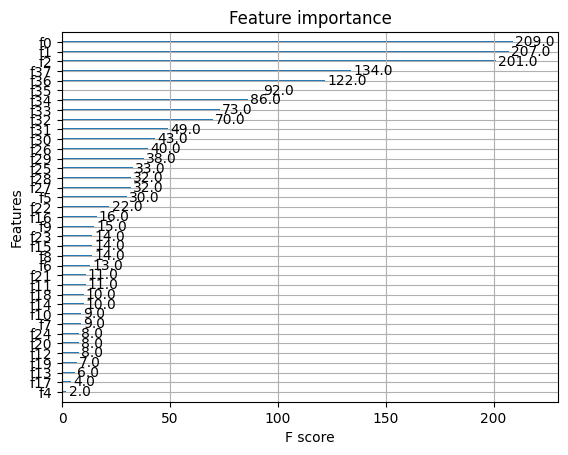

In [ ]:
xgb.plot_importance(bst)

Так как мы рассматриваем данную задачу, как Time Series предсказание определенных временных рядов, то удаим из выборки отсутвующие в тестовой выборке магазины и товары.

In [ ]:
test_shop_ids = df_test['shop_id'].unique()
test_item_ids = df_test['item_id'].unique()
# Only shops that exist in test set.
lk_train = df[df['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]
print('Data set size before leaking:', df.shape[0])
print('Data set size after leaking:', lk_train.shape[0])

Data set size before leaking: 2933228
Data set size after leaking: 1223172


In [ ]:
# Сгруппируем данные по месяцам
train_monthly = lk_train.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'sum_item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'col_transactions']

In [ ]:
train_monthly

,date_block_num,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,item_cnt,mean_item_cnt,col_transactions
0,0,2,2,5572,10730.00,1532.86,9,1.29,7
1,0,2,2,5643,4775.21,2387.61,0,0.00,2
2,0,2,5,5583,1188.30,594.15,2,1.00,2
3,0,2,6,7893,5970.00,1990.00,3,1.00,3
4,0,2,6,7894,1490.00,1490.00,1,1.00,1
...,...,...,...,...,...,...,...,...,...
600093,33,59,75,5383,4390.00,4390.00,1,1.00,1
600094,33,59,79,17717,8025.50,802.55,13,1.30,10
600095,33,59,83,22087,357.00,119.00,6,2.00,3
600096,33,59,83,22088,238.00,119.00,2,1.00,2


По условию из описания kaggle, список магазинов и товаров может меняться из месяца к месяцу. Но для корректного расчета лагов пропуски в данных не должны быть. Создадим пустой датафрейм,в котором есть по всем позициям и по всем магазинам данные продаж и сольем его с нашим датасетом, посмотрим, сколько у нас пропусков и каким образом их лучше всего заполнить.



In [ ]:
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])

empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

Заполним датасет данными из тренироваочной выборки

In [ ]:
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)

Воспользуемся нашим классом чтобы сгенерировать признаки из метки времени и названия магазина

In [ ]:
class DataProcessor:
    def __init__(self, df_cities, df_category):
        self.df_cities = df_cities
        self.df_category = df_category

    def process_data(self, data):
        data = pd.merge(data, self.df_category, on="item_id", how="left")
        data = pd.merge(data, self.df_cities, on="shop_id", how="left")
        data['year'] = data['date_block_num'].apply(lambda x: ((x // 12) + 2013))
        data['season'] = data['date_block_num'].apply(lambda x: (x % 4))
        data['month'] = data['date_block_num'].apply(lambda x: (x % 12))
        return data

data = train_monthly.copy()
# Создаем экземпляр класса DataProcessor
processor = DataProcessor(df_cities, df_category)
# Обрабатываем данные с помощью метода process_data
processed_data = processor.process_data(data)

In [ ]:
processed_data

,date_block_num,shop_id,item_id,item_category_id,sum_item_price,mean_item_price,item_cnt,mean_item_cnt,col_transactions,category,city,year,season,month
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,Аксессуары,Адыгея,2013,0,0
1,0,2,5643,2.00,4775.21,2387.61,0.00,0.00,2.00,Аксессуары,Адыгея,2013,0,0
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,Аксессуары,Адыгея,2013,0,0
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,Аксессуары,Адыгея,2013,0,0
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,Аксессуары,Адыгея,2013,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6734443,33,36,9103,0.00,0.00,0.00,0.00,0.00,0.00,Книги,Новосибирск,2015,1,9
6734444,33,36,9107,0.00,0.00,0.00,0.00,0.00,0.00,Книги,Новосибирск,2015,1,9
6734445,33,36,5704,0.00,0.00,0.00,0.00,0.00,0.00,Программы,Новосибирск,2015,1,9
6734446,33,36,12733,0.00,0.00,0.00,0.00,0.00,0.00,Программы,Новосибирск,2015,1,9


Creating the label
['item_cnt'].shift(-1): Эта часть кода применяет метод shift(-1) к столбцу 'item_cnt' в каждой группе. Метод shift(-1) сдвигает значения в столбце на одну строку вверх, то есть значения 'item_cnt' для каждого месяца сдвигаются на одну строку вверх, что приводит к значениям 'item_cnt' для следующего месяца.
Создадим новый столбец 'item_cnt_month', который содержит значения 'item_cnt' для следующего месяца для каждой пары магазин-товар в исходных данных.

In [ ]:
train_monthly1 = train_monthly.copy()
train_monthly1['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

In [ ]:
train_monthly1

,date_block_num,shop_id,item_id,item_category_id,sum_item_price,mean_item_price,item_cnt,mean_item_cnt,col_transactions,item_cnt_month
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,1.00
1,0,2,5643,2.00,4775.21,2387.61,0.00,0.00,2.00,0.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,1.00
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2.00
...,...,...,...,...,...,...,...,...,...,...
6734443,33,36,9103,0.00,0.00,0.00,0.00,0.00,0.00,NaN
6734444,33,36,9107,0.00,0.00,0.00,0.00,0.00,0.00,NaN
6734445,33,36,5704,0.00,0.00,0.00,0.00,0.00,0.00,NaN
6734446,33,36,12733,0.00,0.00,0.00,0.00,0.00,0.00,NaN


In [ ]:
train_monthly1.to_csv('train_monthly1.csv')

In [ ]:
# # Build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing records.
# shop_ids = train_monthly['shop_id'].unique()
# item_ids = train_monthly['item_id'].unique()
# empty_df = []
# for i in range(34):
#     for shop in shop_ids:
#         for item in item_ids:
#             empty_df.append([i, shop, item])

# empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [ ]:
# # Merge the train set with the complete set (missing records will be filled with 0).
# train_monthly = pd.merge(empty_df, processed_data, on=['date_block_num','shop_id','item_id'], how='left')
# # train_monthly.fillna(0, inplace=True)
#Расчет пропусков в процентах
pd.DataFrame(train_monthly.isnull().sum()/len(train_monthly)*100, columns = ['Количество пропусков (%)'])

In [ ]:
# def filter_outliers_by_category(df, method='quantiles', lower_quantile=0.01, upper_quantile=0.99, z_score_threshold=3, groupby_column='category'):
#     if method == 'quantiles':
#         outlier_mask = df.groupby(groupby_column)['item_cnt_day'].transform(
#             lambda x: (x < x.quantile(lower_quantile)) | (x > x.quantile(upper_quantile))
#         )
#     elif method == 'z_score':
#         outlier_mask = df.groupby(groupby_column)['item_cnt_day'].transform(
#             lambda x: np.abs((x - x.mean()) / x.std()) > z_score_threshold
#         )
#     else:
#         raise ValueError("Invalid method provided. Choose either 'quantiles' or 'z_score'.")

#     filtered_df = df[~outlier_mask]
#     return filtered_df

# # Assuming your DataFrame is named df, you can call the function like this
# filtered_df = filter_outliers_by_category(sales_train_full, method='quantiles')
# print('Before drop shape:', sales_train_full.shape)
# before = sales_train_full.shape[0]
# print('After drop shape:', filtered_df.shape)
# after = filtered_df.shape[0]
# print('Total Duplicate:', before-after)

# Посмотрим, сколько уникальных категорий в датасете и, в случае, если их очень много, попробуем агрегировать их в более курпные группы

In [ ]:
len(list(df_item_cat.item_category_id.unique()))

84

Укрупним пока простой эвристикой, позже, если понадобится, сделаем более мелкое деление на группы

In [ ]:
# Напишем функцию, которая будет получать первое слово из строки, для обозначения категории
def assign_cat(row):
    category = str(row).split()[1].strip()
    return category
df_item_cat['category'] = df_item_cat.apply(assign_cat, axis=1)
# Удалим название категории, т.к. их слишком много, мы будем использовать агрегированные данные
df_item_cat.drop('item_category_name',axis=1, inplace=True)
df_item_cat.head()

,item_category_id,category
0,0,PC
1,1,Аксессуары
2,2,Аксессуары
3,3,Аксессуары
4,4,Аксессуары


In [ ]:
# Посмотрим, сколько получилось категорий
df_item_cat.category.value_counts()

Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: category, dtype: int64

Объединим датасеты df_item_cat и df_items для дальнейшего слияния с общим тренировочным датасетом

In [ ]:
df_items = df_items.merge(df_item_cat, on="item_category_id", how="left")
df_items.head()

,item_name,item_id,item_category_id,category
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,Программы
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино
4,***КОРОБКА (СТЕКЛО) D,4,40,Кино


Удалим названия товаров и item_category_id, чтоды облегчить дальнейшия операции слияния.

In [ ]:
df_items = df_items.drop(labels = ['item_name','item_category_id'], axis = 1)
df_items.head()

,item_id,item_category_id,category
0,0,40,Кино
1,1,76,Программы
2,2,40,Кино
3,3,40,Кино
4,4,40,Кино


# **Analys of shops**

In [ ]:
# df_shops = pd.read_csv("/content/drive/MyDrive/Predict Future Sales/shops.csv")
df_shops.info()
df_shops.describe()
df_shops.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


Попробуем по shop_name выделить новый признак - наименование города, которое потом можно с помощью One Hot incoding закадировать. Т.к. признак будет отражать размер города, в котором находится магазин, думаю, в будущем стоит обратиться за внешней информацией и внести дополнительный признак - численность города.
Сразу удалим shop_name.

In [ ]:
# Напишем функцию, которая будет получать первое слово из строки, для обозначения города
def assign_city(row):
    city = str(row).split()[1].strip()
    return city
df_shops['City'] = df_shops.apply(assign_city, axis=1)
# Удалим лишние знаки, чтобы слить одинаковые города
df_shops['City'] = df_shops.City.apply(lambda x: x.replace("!",""))
df_shops.drop('shop_name',axis=1, inplace=True)
df_shops.head()

,shop_id,City
0,0,Якутск
1,1,Якутск
2,2,Адыгея
3,3,Балашиха
4,4,Волжский


In [ ]:
# Посмотрим, сколько городов у нас получилось и нет ли дубликатов из-за орфографии
df_shops.City.value_counts()

Москва              13
Якутск               4
РостовНаДону         3
Воронеж              3
Тюмень               3
Новосибирск          2
Н.Новгород           2
Самара               2
Красноярск           2
Казань               2
Жуковский            2
Уфа                  2
СПб                  2
Томск                1
Сургут               1
Сергиев              1
Химки                1
Цифровой             1
Чехов                1
Мытищи               1
Омск                 1
Адыгея               1
Курск                1
Коломна              1
Калуга               1
Интернет-магазин     1
Выездная             1
Вологда              1
Волжский             1
Балашиха             1
Ярославль            1
Name: City, dtype: int64

Давайте обогатим наш датасет внешними данными и внесем численность населения в признаковое пространство



In [ ]:
url = 'https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D0%BE%D0%B2_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8'
df_population = pd.read_html(url)[0]
df_population = df_population[['Город', 'Население']]
df_population = df_population.rename(columns={'Город': 'City', 'Население': 'Population'})
df_population
df_population['Population'] = df_population.Population.apply(lambda x: x.replace("[2]",""))
# df_population['Population'] = df_population.Population.apply(lambda x: int(x.replace("[2]","")))

In [ ]:
df_population['Population'] = df_population.Population.apply(lambda x: x.replace("[3]",""))
df_population['Population'] = df_population.Population.apply(lambda x: int(x.replace(" ","")))

In [ ]:
# Заменим на правильные наименовани городов
# will remap the values
dict = {'СПб' : 'Санкт-Петербург', 'РостовНаДону' : 'Ростов-на-Дону', 'Н.Новгород' : 'Нижний Новгород'}
# Remap the values of the dataframe
df_shops = df_shops.replace({"City": dict})

In [ ]:
def fill_population(df_shops, df_population):
    # Merge the two datasets on the 'City' column
    merged_df = df_shops.merge(df_population, on='City', how='left')

    # Fill missing values in the 'Population' column with the average population
    avg_population = 60000
    merged_df['Population'] = merged_df['Population'].fillna(avg_population)

    return merged_df

# Assuming 'shop_id' is the index of df_shops, you can call the function like this
df_shops_with_population = fill_population(df_shops, df_population)
df_shops_with_population

,shop_id,City,Population
0,0,Якутск,355443.0
1,1,Якутск,355443.0
2,2,Адыгея,60000.0
3,3,Балашиха,520962.0
4,4,Волжский,321479.0
5,5,Вологда,313944.0
6,6,Воронеж,1057681.0
7,7,Воронеж,1057681.0
8,8,Воронеж,1057681.0
9,9,Выездная,60000.0


In [ ]:
df_shops_with_population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   shop_id     60 non-null     int64  
 1   City        60 non-null     object 
 2   Population  60 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.9+ KB


Теперь можно объединить наш датасет sales_train с датасетом категорий и датасетом магазинов в один и затем проверить на дубликаты.

In [ ]:
sales_train_full = sales_train.merge(df_items, on="item_id", how="left")
sales_train_full

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,category
0,2013-01-02,0,59,22154,999.0,1.0,Кино
1,2013-01-03,0,25,2574,399.0,2.0,Музыка
2,2013-01-05,0,25,2574,399.0,1.0,Музыка
3,2013-01-07,0,25,2574,399.0,1.0,Музыка
4,2013-01-08,0,25,2574,399.0,2.0,Музыка
...,...,...,...,...,...,...,...
1224434,2015-10-10,33,25,7409,299.0,1.0,Музыка
1224435,2015-10-09,33,25,7460,299.0,1.0,Музыка
1224436,2015-10-14,33,25,7459,349.0,1.0,Музыка
1224437,2015-10-22,33,25,7440,299.0,1.0,Музыка


In [ ]:
sales_train_full = sales_train_full.merge(df_shops_with_population, on="shop_id", how="left")
sales_train_full

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,category,City,Population
0,2013-01-02,0,59,22154,999.0,1.0,Кино,Ярославль,577279.0
1,2013-01-03,0,25,2574,399.0,2.0,Музыка,Москва,13010112.0
2,2013-01-05,0,25,2574,399.0,1.0,Музыка,Москва,13010112.0
3,2013-01-07,0,25,2574,399.0,1.0,Музыка,Москва,13010112.0
4,2013-01-08,0,25,2574,399.0,2.0,Музыка,Москва,13010112.0
...,...,...,...,...,...,...,...,...,...
1224434,2015-10-10,33,25,7409,299.0,1.0,Музыка,Москва,13010112.0
1224435,2015-10-09,33,25,7460,299.0,1.0,Музыка,Москва,13010112.0
1224436,2015-10-14,33,25,7459,349.0,1.0,Музыка,Москва,13010112.0
1224437,2015-10-22,33,25,7440,299.0,1.0,Музыка,Москва,13010112.0


Думаю, стоит выделить отдельным признаком сезон (как номер квартала), в который был продан товар и удалить даты - у нас есть номер недели, возможно, этого было бы достаточно.

In [ ]:
sales_train_full['quarter'] = pd.PeriodIndex(sales_train_full.date, freq='Q')
# Возьмем последнюю цифру, обозначающую номер квартала (сезон)
sales_train_full['quarter'] = sales_train_full.quarter.astype(str).apply(lambda x: str(x[-1]))

In [ ]:
sales_train_full

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,category,City,Population,quarter
0,2013-01-02,0,59,22154,999.0,1.0,Кино,Ярославль,577279.0,1
1,2013-01-03,0,25,2574,399.0,2.0,Музыка,Москва,13010112.0,1
2,2013-01-05,0,25,2574,399.0,1.0,Музыка,Москва,13010112.0,1
3,2013-01-07,0,25,2574,399.0,1.0,Музыка,Москва,13010112.0,1
4,2013-01-08,0,25,2574,399.0,2.0,Музыка,Москва,13010112.0,1
...,...,...,...,...,...,...,...,...,...,...
1224434,2015-10-10,33,25,7409,299.0,1.0,Музыка,Москва,13010112.0,4
1224435,2015-10-09,33,25,7460,299.0,1.0,Музыка,Москва,13010112.0,4
1224436,2015-10-14,33,25,7459,349.0,1.0,Музыка,Москва,13010112.0,4
1224437,2015-10-22,33,25,7440,299.0,1.0,Музыка,Москва,13010112.0,4


Перерь можно проветить на дубликаты. Дубликатами будем считать, если одна и та же позиция, в одном и том же магазине в одну и ту же дату и за одну и ту же цену возникла в датасете. Напишем функцию.

In [ ]:
def drop_duplicate(data, subset):
    print('Before drop shape:', data.shape)
    before = data.shape[0]
    data.drop_duplicates(subset,keep='first', inplace=True)
    data.reset_index(drop=True, inplace=True)
    print('After drop shape:', data.shape)
    after = data.shape[0]
    print('Total Duplicate:', before-after)

In [ ]:
subset =['date','shop_id','item_id','item_price']
drop_duplicate(sales_train_full,subset=subset)

Before drop shape: (1224439, 10)
After drop shape: (1224434, 10)
Total Duplicate: 5


# Посмотрим на выбросы в продажах, но в пределах каждой категории товаров
Возможно, придется в будущем умельчить категории для более точного разделения и выбросы будут уменьшены

In [ ]:
def filter_outliers_by_category(df, method='quantiles', lower_quantile=0.01, upper_quantile=0.99, z_score_threshold=3, groupby_column='category'):
    if method == 'quantiles':
        outlier_mask = df.groupby(groupby_column)['item_cnt_day'].transform(
            lambda x: (x < x.quantile(lower_quantile)) | (x > x.quantile(upper_quantile))
        )
    elif method == 'z_score':
        outlier_mask = df.groupby(groupby_column)['item_cnt_day'].transform(
            lambda x: np.abs((x - x.mean()) / x.std()) > z_score_threshold
        )
    else:
        raise ValueError("Invalid method provided. Choose either 'quantiles' or 'z_score'.")

    filtered_df = df[~outlier_mask]
    return filtered_df

# Assuming your DataFrame is named df, you can call the function like this
filtered_df = filter_outliers_by_category(sales_train_full, method='quantiles')
print('Before drop shape:', sales_train_full.shape)
before = sales_train_full.shape[0]
print('After drop shape:', filtered_df.shape)
after = filtered_df.shape[0]
print('Total Duplicate:', before-after)
# Or if you prefer using z-scores:
# filtered_df = filter_outliers_by_category(df, method='z_score', z_score_threshold=3)

Before drop shape: (1224434, 10)
After drop shape: (1211734, 10)
Total Duplicate: 12700


Удалим ненужные колонки и датасет готов к следующему этапу  - ELT.

In [ ]:
filtered_df = filtered_df.drop(labels = ['date','item_id', 'item_price'], axis = 1)

In [ ]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1211734 entries, 0 to 1224433
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date_block_num  1211734 non-null  int64  
 1   shop_id         1211734 non-null  int64  
 2   item_price      1211734 non-null  float64
 3   item_cnt_day    1211734 non-null  float64
 4   category        1211734 non-null  object 
 5   City            1211734 non-null  object 
 6   Population      1211734 non-null  float64
 7   quarter         1211734 non-null  object 
dtypes: float64(3), int64(2), object(3)
memory usage: 83.2+ MB


ВОПРОСЫ:
1. Правильно ли я сделала вывод  о том, что нужно убрать из модели магазины, которых нет в тестовом наборе (по некоторым из них почти нет данных продаж)?
2. Правильно ли я сделала вывод  о том, что нужно убрать из модели товары (item_id), которых нет в тестовом наборе или лучше их оставить?
3. Я сомневаюсь, что нужно было удалять выбросы, так как я совсем не знаю причину их происходжения, может, это не ошибка, а особенность данных. Тем более, в первую очередь я хочу попробовать XGBoost (или CatBoost), который неплохо работает с выбросами, но и RNN тоже можно было попробовать. Как ты думаешь, стоит ли это делать?
4. Как ты думаешь, стоило ли заморачиваться по поводу новых фичей category	City, Population и quarter? Особенно с Population, для которого придется отдельно прописывать код для поиска значения при обработке input значений в модель?...
5. Может быть я что-то упустила?

Я работаю в Google collab (у меня есть подписка и я могу здесь на GPU обучать модели), но я бы хотела потом оформить все в виде скриптов и модулей (используя ООП), но только после того, как мы обсудим первые 2 этапа.

То, что удивило:

In [ ]:
gp_item_price = processed_data.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price

In [ ]:
pd.DataFrame(train_monthly.isnull().sum()/len(train_monthly)*100, columns = ['Количество пропусков (%)'])